In [5]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylabㅌ
import pandas as pd
import seaborn as sns
import random


from InitializeSpeciesPool import *
from LV import *
from VariousMetrics import *

sns.set_style("ticks")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}



session_name="results/test"


# Function Definition

In [36]:
from scipy.integrate import odeint

'''

def gLV(y, t, I_simul, g_simul, k_simul):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        dydt[i] = g_simul[i]* y[i] * (1- np.sum(I_simul[i,:] * y)/k_simul[i])
    return dydt

def run_lotka_volterra_dynamics(y0, t, s_idx, I, g, k):
    
    s_idx=np.where(s_idx)[0].tolist()
    N=len(y0)
    y0_simul=y0[s_idx]
    I_simul=I[s_idx,:]
    I_simul=I_simul[:,s_idx]
    g_simul=g[s_idx]
    k_simul=k[s_idx]
    
    
    y = odeint(gLV, y0_simul, t, args=(I_simul, g_simul, k_simul))
    y_out=np.zeros(N)
    for i in range(y.shape[1]):
        y_out[s_idx[i]]=y[-1,i] 
    return y
'''
def gLV_env(y, t, beta, delta, migration_rate, I, g, k, p, q, varIdx):
    # p : species -> pH
    # q : pH -> species
    dydt = np.zeros(len(varIdx['env']) + len(varIdx['species']))
    
    growth_rate_multiplier = 1 - (np.matmul(I, y[varIdx['species']])) / k + np.matmul(q, y[varIdx['env']])
    
    dydt[varIdx['species']] = np.multiply(np.multiply(y[varIdx['species']], g), growth_rate_multiplier) + migration_rate #- death_rate * y[varIdx['species']]
    dydt[varIdx['env']] = delta * (-y[varIdx['env']]) + beta* np.matmul(p, y[varIdx['species']]) - delta * 0.0001 * y[varIdx['env']]**5
    
    return dydt

def run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False):
    

    N=system_config['N']
    N_env=system_config['N_env']
    beta = system_config['beta']
    delta = system_config['delta']
    migration_rate = system_config['migration_rate']
    I = system_config['I']
    g = system_config['g']
    k = system_config['k']
    p = system_config['p']
    q = system_config['q']
                                   
    I=I[species_index,:]
    I=I[:,species_index]
    g=g[species_index]
    k=k[species_index]
    p=p[:,species_index] # p is N_env x N
    p=p[env_index,:]                               
    q=q[species_index,:] # q is N x N_Nev
    q=q[:,env_index]                             
    
    varIdx={'species' : np.arange(len(species_index)),
           'env' : np.arange(len(species_index),len(species_index)+len(env_index))}
    y0=np.concatenate((y0_species, y0_env))
    
    y = odeint(gLV_env, y0, t, args=(beta, delta, migration_rate, I, g, k, p, q, varIdx), atol=1e-12, rtol=1e-10)
    y_out={}
    y_out_species=np.zeros(N)
    y_out_env=np.zeros(N_env)

    for i in range(len(species_index)):
        y_out_species[species_index[i]]=y[-1,i]
        y_out['species']=y_out_species
    for i in range(len(env_index)):
        y_out_env[env_index[i]]=y[-1,len(species_index)+i]
        y_out['env']=y_out_env
    
    if to_plot:
        # Create plots
        fig, axs = plt.subplots(2, 1, figsize=(7, 6))  # 2 Rows, 1 Column

        # Plotting species data
        for i in range(len(species_index)):
            axs[0].plot(t, y[:, i], label=f'Species {i+1}')
        axs[0].set_title('Species Time Series')
        axs[0].set_xlabel('Time (log scale)')
        axs[0].set_ylabel('Value (log scale)')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].axhline(y=1e-6, color='r', linestyle='dotted', linewidth=1)
        axs[0].set_ylim(1e-6, 100)

        axs[0].legend()

        # Plotting environmental data
        for i in range(len(env_index)):
            axs[1].plot(t, y[:, len(species_index)+i], label=f'Env Variable {i+1}')
        axs[1].set_title('Environmental Variables Time Series')
        axs[1].set_xlabel('Time (log scale)')
        axs[1].set_ylabel('Env Value')
        axs[1].set_xscale('log')
        axs[1].legend()

        
        plt.tight_layout()
        plt.show()
    print(y_out)
    return y_out


# PARAMETER DEFINITION

In [7]:
def uniform_distribution(u,o):
    return u+(2*o)*np.random.random()-o

def input_distribution(k):
    return np.random.exponential(k)

In [8]:
np.random.normal(loc=0, scale=1)

1.3599804850879367

In [9]:
session_path='Results/Session_Test1'

if not os.path.isdir(session_path):
    os.mkdir(session_path)
# functions for uniform 

f_I = lambda : uniform_distribution(0.7,0.5)
f_g = lambda : np.ones(1)
f_k = lambda : np.ones(1)
f_p = lambda : uniform_distribution(0.4,0.6)
f_q = lambda : uniform_distribution(0.4,0.6)
f_beta = lambda : np.ones(1)
seed_num=48

np.random.seed(seed_num)




N=24
N_env=1


I = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        I[i,j] = f_I()
for i in range(N):
    I[i,i] =1

g = np.zeros((N))
for i in range(N):
    g[i] = f_g()

k = np.zeros((N))
for i in range(N):
    k[i] = f_k()   

p = np.zeros((N_env, N))
for i in range(N_env):
    for j in range(N):
        p[i,j] = f_p()

p[0,0]=-20

q = np.zeros((N, N_env))
for i in range(N):
    for j in range(N_env):
        q[i,j] = f_q()
        
q[0,0]=0.2


beta = np.zeros(N_env)
for i in range(N_env):
    beta[i]=f_beta()

delta = 0.1 ## ln(100000)/24 ~= 0.5 per hour
migration_rate=0#1e-7
system_config = {
    'I': I,
    'g': g,
    'k': k,
    'p': p,
    'q': q,
    'beta': beta,
    'delta': delta,
    'migration_rate' : migration_rate,
    'N': N,
    'N_env': N_env,
    'seed_num':seed_num,
} 

file_path = f'{session_path}/system_config.json'



In [10]:
def one_hot_vector(n_species,i):
    # Create an array of length n_species with all values set to 0.001
    vector = np.full(n_species, 0.0001)
    
    # Set the ith element to 0.1
    vector[i] = 0.01
    
    return vector

In [38]:
def plot_states_from_cfg(system_config):
    for i in range(12):
        y_out_list=[]
        y0_species=one_hot_vector(12,i)
        y0_env=[0]
        t=np.linspace(0, 2000, 10000)

        y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

        y_out_list.append(y_out)
    #print(np.sum(y_out['species']), np.sum(y_out['env']) )
    num_datasets = len(y_out_list)

    # Prepare subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    # Data for plots
    species_matrix = np.array([y_out['species'] for y_out in y_out_list])
    env_data = np.array([y_out['env'][0] for y_out in y_out_list])  # Assuming env is a single-element array

    # Normalize species data
    species_matrix = np.maximum(species_matrix, 0)  # Removing negative values for normalization
    species_sums = np.sum(species_matrix, axis=1, keepdims=True)
    normalized_species = species_matrix / species_sums

    # Bar width
    bar_width = 0.8 / num_datasets  # Adjust bar width based on the number of datasets

    # Plotting species composition
    for i in range(normalized_species.shape[1]):  # Loop through each species
        axs[0].bar(np.arange(num_datasets) + i * bar_width, normalized_species[:, i], bar_width, label=f'Species {i+1}')

    axs[0].set_title('Normalized Species Composition')
    axs[0].set_xlabel('Dataset Index')
    axs[0].set_ylabel('Proportion')
    axs[0].legend()

    # Plotting environmental factors
    axs[1].bar(np.arange(num_datasets), env_data, color='red', width=0.8)
    axs[1].set_title('Environmental Variable')
    axs[1].set_xlabel('Dataset Index')
    axs[1].set_ylabel('Environmental Value')

    plt.tight_layout()
    plt.show()

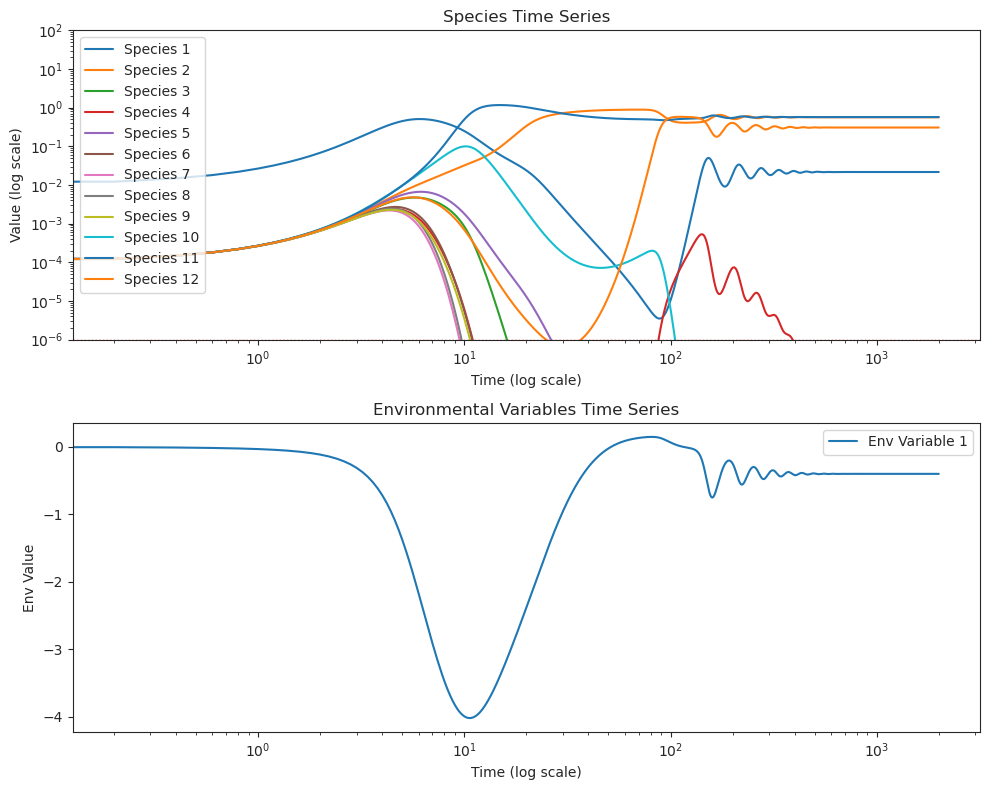

{'species': array([ 2.16528982e-002,  5.63911996e-001,  6.93558402e-310,
        2.59518900e-020,  5.00885903e-077, -6.30431388e-302,
        2.34181456e-261, -9.95264675e-080,  9.15559681e-293,
        1.50478388e-189,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


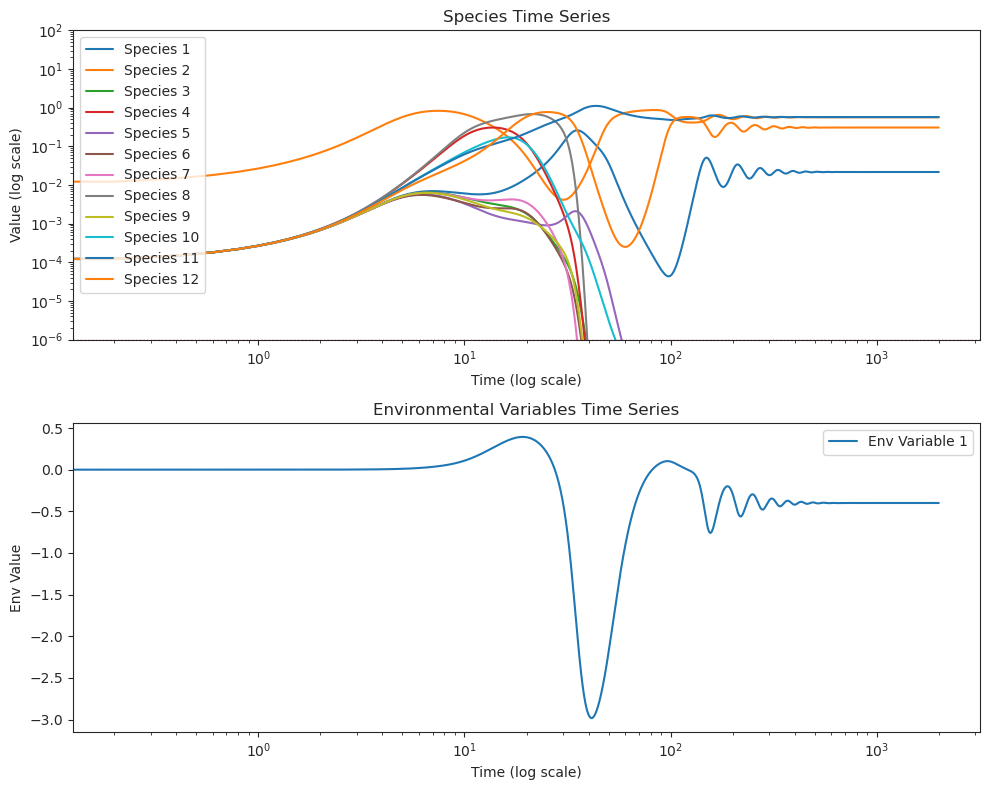

{'species': array([ 2.16528982e-002,  5.63911996e-001,  1.93673678e-313,
        1.52814105e-025,  2.38396620e-076, -7.52751690e-306,
        3.95316892e-257,  7.25480811e-082, -9.10992076e-289,
       -9.23302823e-195,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


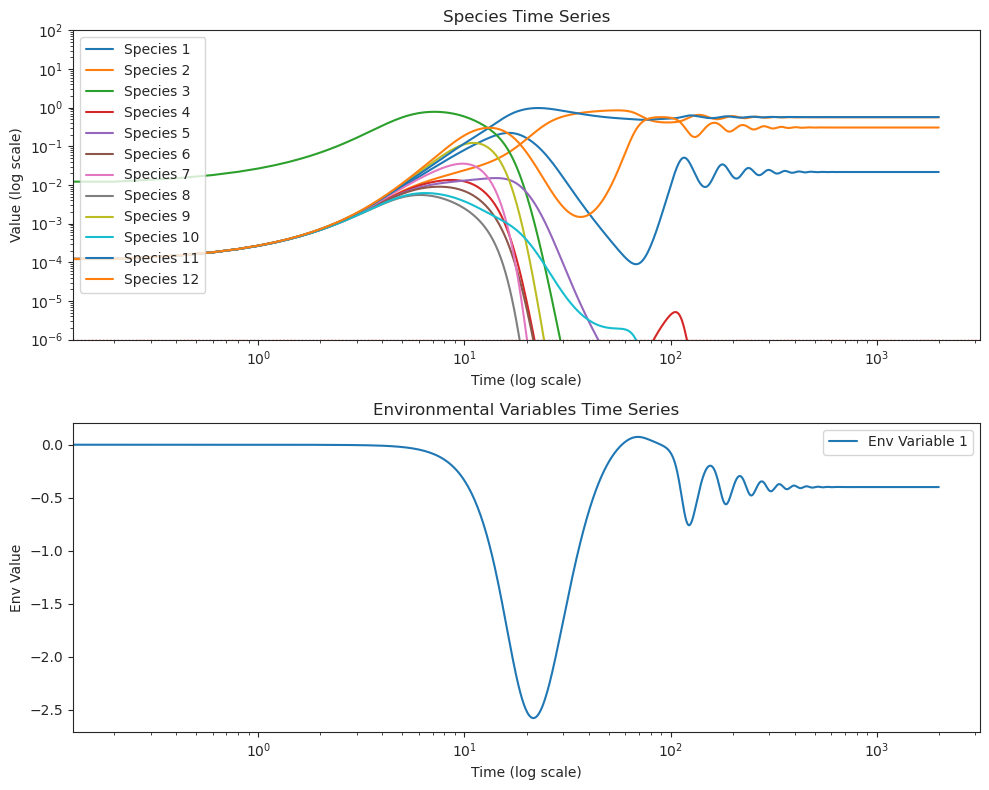

{'species': array([ 2.16528982e-002,  5.63911997e-001, -3.70328345e-313,
        1.21007411e-022,  3.29971501e-076,  4.07010684e-311,
       -9.67877981e-256,  1.58279864e-084, -2.29010429e-292,
       -1.71923822e-194,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


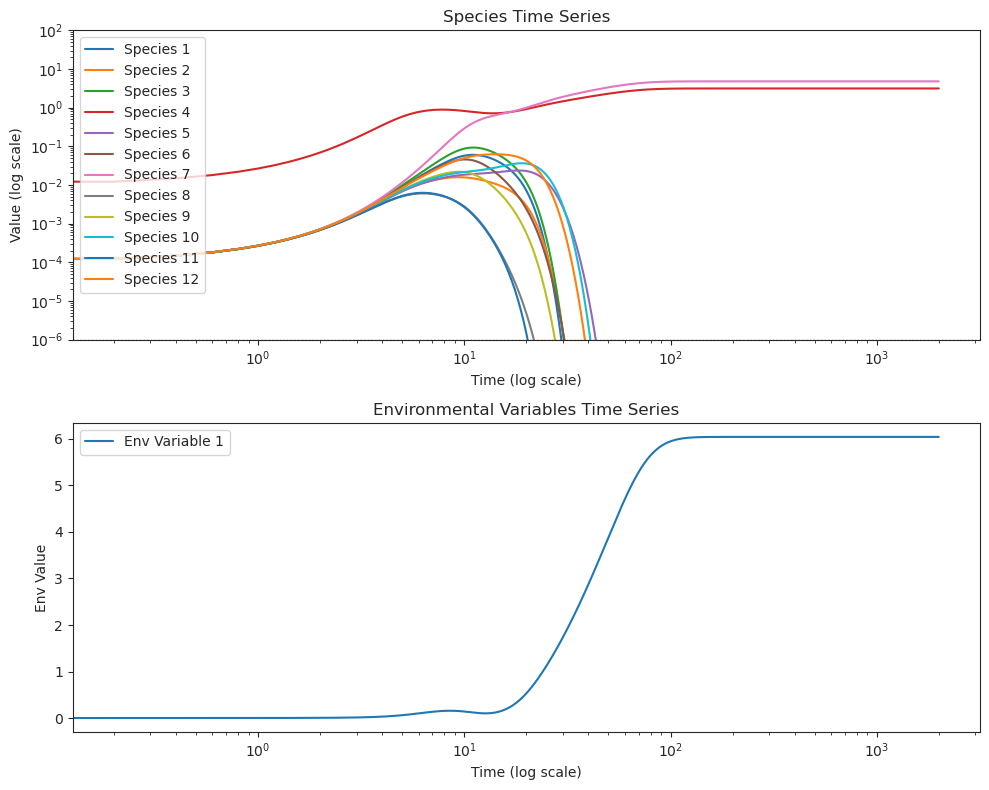

{'species': array([ 1.85258994e-50,  2.72024854e-51, -1.95459337e-50,  3.13625607e+00,
       -2.70780102e-44,  1.88632816e-49,  4.79107529e+00,  1.75443402e-56,
       -1.07342711e-52, -2.00134643e-42,  4.37876051e-39, -1.37293020e-43,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}


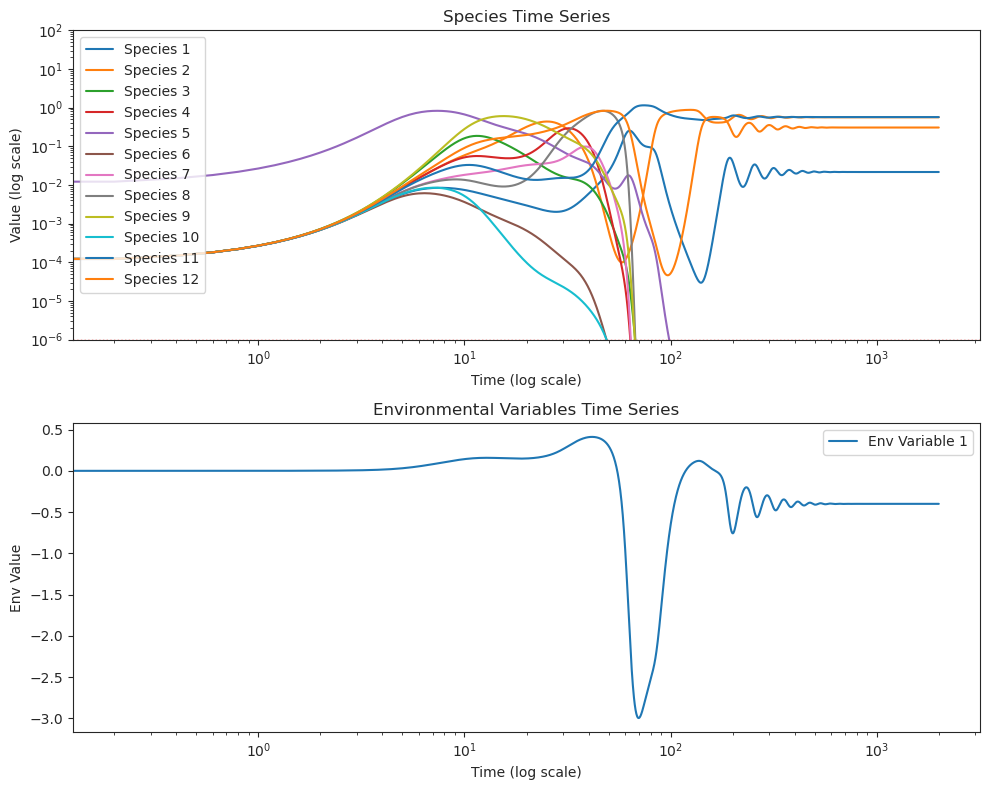

{'species': array([ 2.16528982e-002,  5.63911996e-001, -2.86328100e-254,
        8.09203303e-030,  1.26484362e-073,  8.81023243e-245,
        1.56940994e-234, -1.77949139e-075, -3.60014820e-225,
       -2.93777146e-157,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


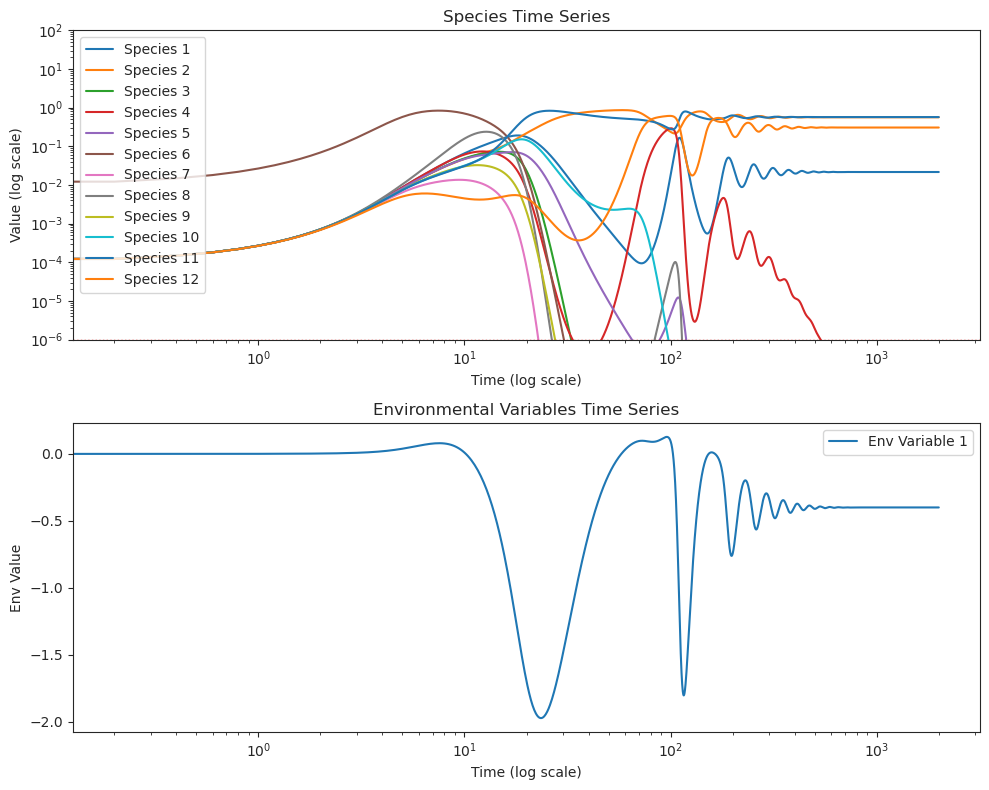

{'species': array([ 2.16528982e-002,  5.63911996e-001, -6.23480787e-254,
        4.55584597e-019,  1.98477221e-074,  3.19423410e-241,
       -1.69880000e-248,  2.44038515e-077, -1.11698914e-225,
        5.00254922e-153,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


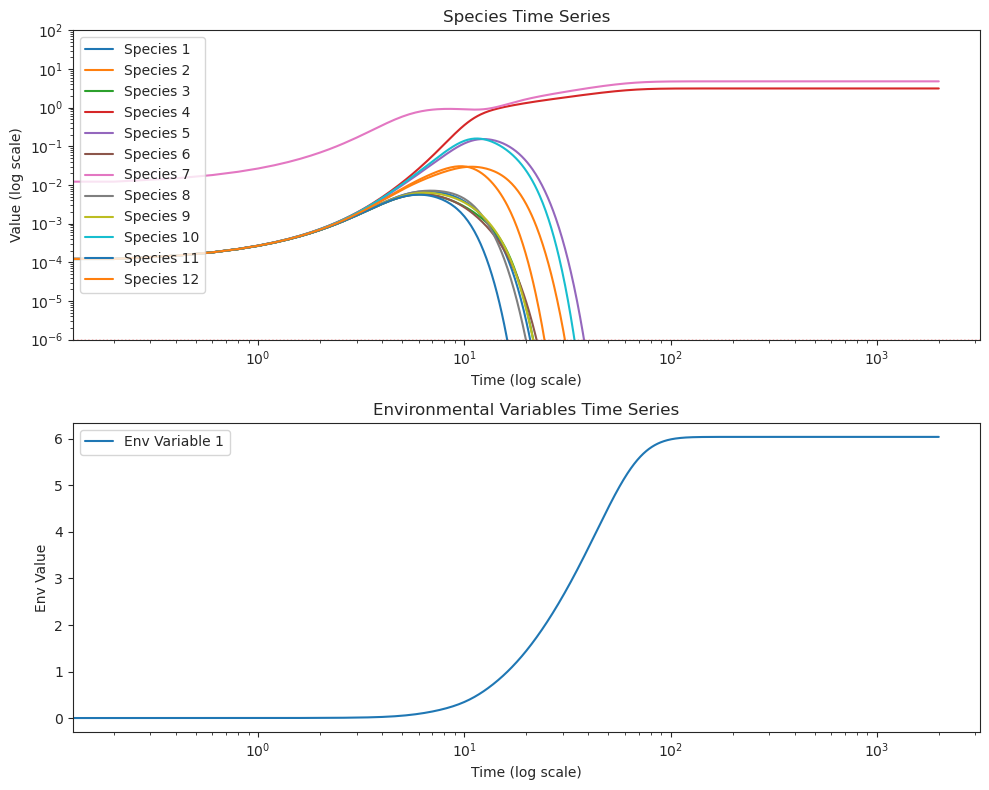

{'species': array([ 3.18126970e-83, -8.79030468e-82,  1.51393060e-84,  3.13625607e+00,
        9.53399932e-58,  1.69383436e-77,  4.79107529e+00,  7.65953230e-87,
        8.00687018e-84, -3.31370276e-64, -2.53090225e-33, -1.47926748e-66,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}


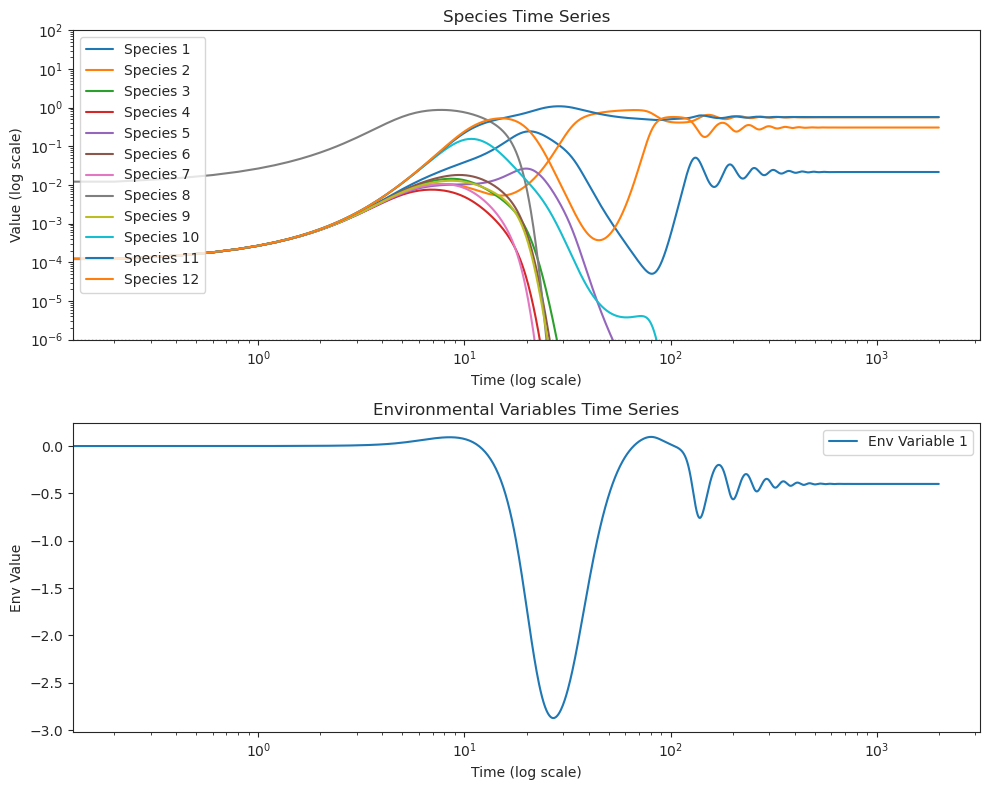

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.92940963e-297,
        1.04453531e-025,  9.76798500e-076, -8.26238001e-290,
       -2.82598466e-250, -1.01699702e-081,  1.55657416e-277,
        2.42227442e-190,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


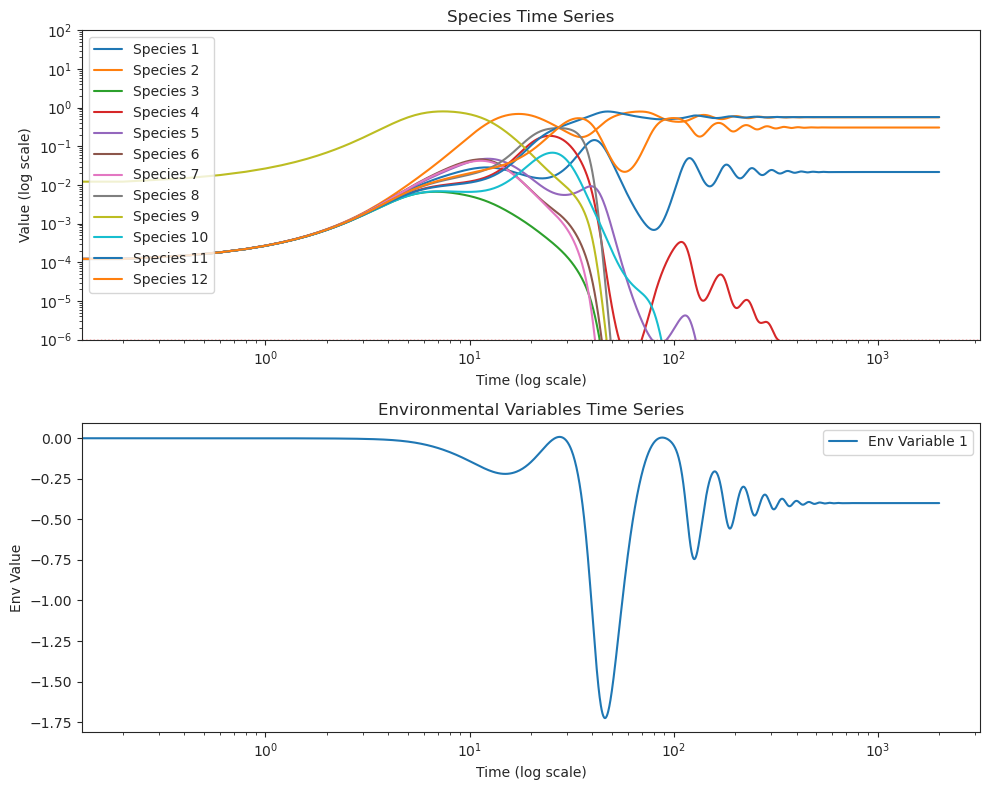

{'species': array([ 2.16528982e-002,  5.63911997e-001, -5.17821713e-303,
        8.98891983e-021,  2.67197800e-075, -1.24547097e-296,
       -1.63435652e-259,  5.58859845e-079,  5.54368394e-283,
       -6.77028571e-191,  5.70365502e-001,  3.06254232e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


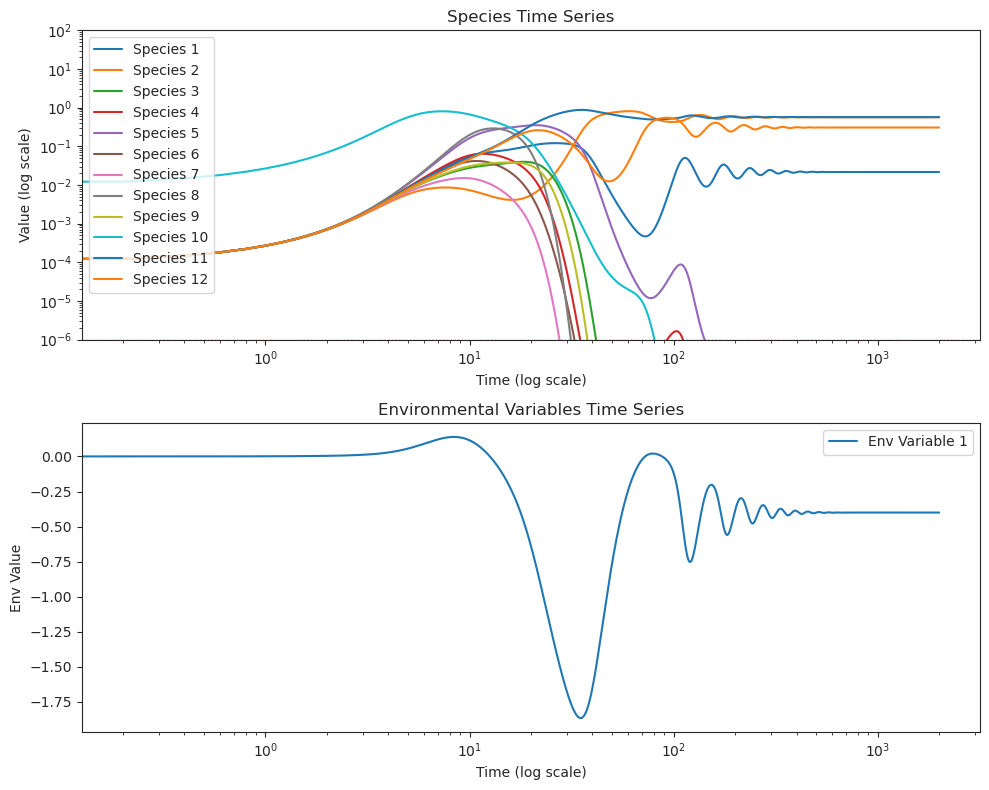

{'species': array([ 2.16528982e-002,  5.63911997e-001, -1.85775031e-295,
        3.83653182e-023,  3.84052284e-074, -1.52072359e-291,
       -6.90170335e-259,  6.89603267e-084, -1.34838939e-280,
        1.99326279e-191,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


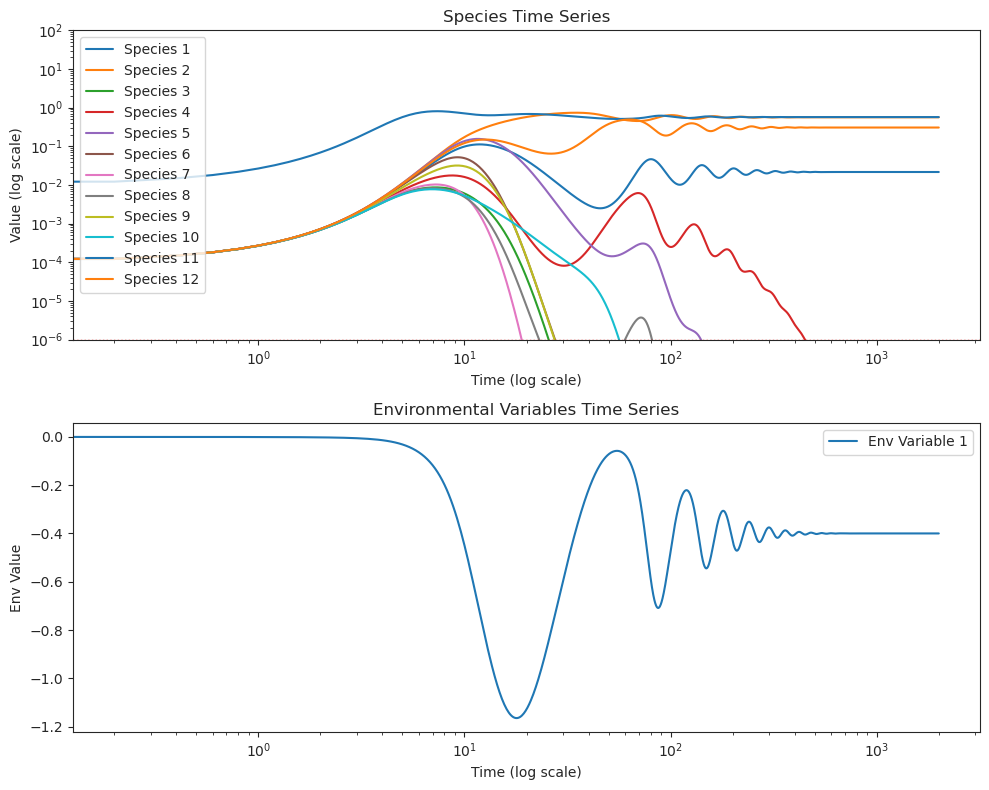

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.20149270e-246,
        8.61669833e-020,  6.48798485e-071,  2.49929571e-234,
       -7.22697870e-223,  5.76002573e-075, -6.13675973e-218,
        1.62446847e-149,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


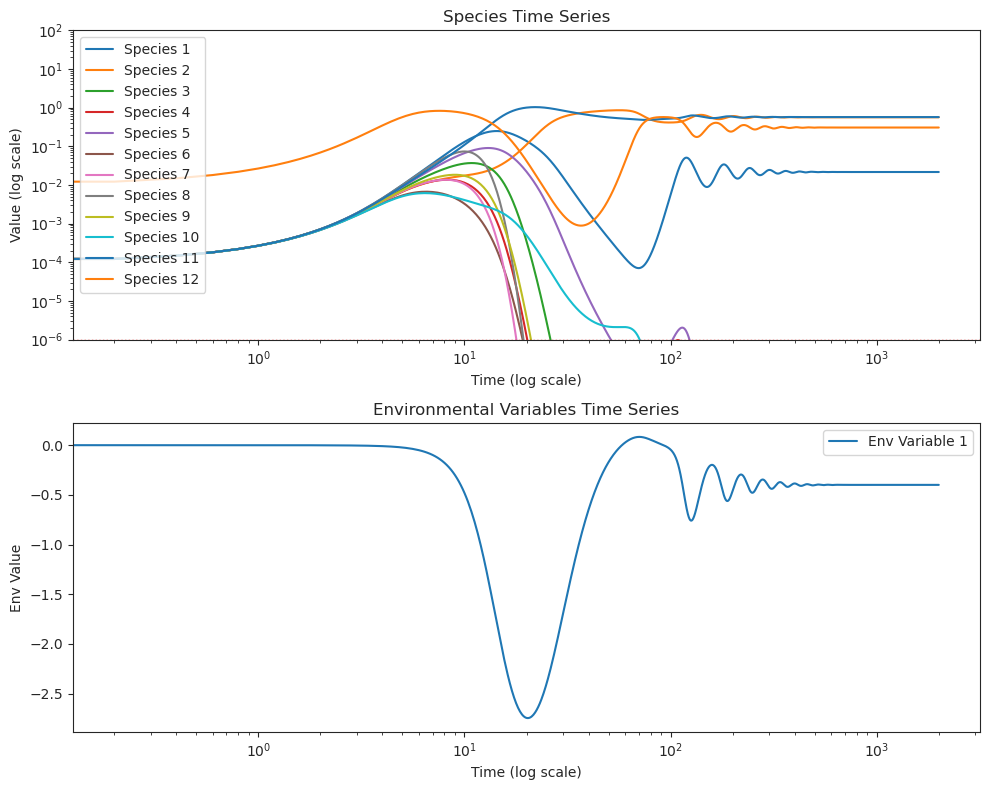

{'species': array([ 2.16528982e-002,  5.63911997e-001,  4.19320614e-266,
        2.40848539e-023, -6.27978659e-073, -6.83292958e-259,
        1.18156904e-226, -1.56781555e-078,  1.51866700e-247,
       -2.32191679e-165,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


In [19]:
    y_out_list=[]

    for i in range(12):
        y0_species=one_hot_vector(12,i)
        y0_env=[0]
        t=np.linspace(0, 2000, 10000)

        y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

        y_out_list.append(y_out)
    

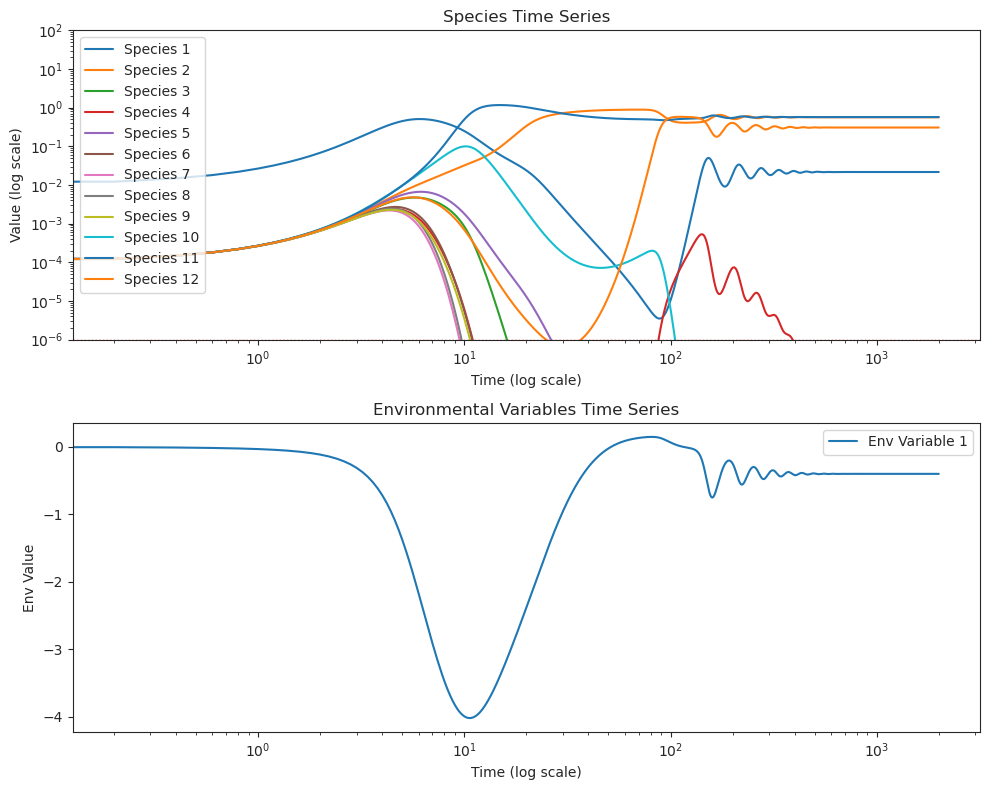

{'species': array([ 2.16528982e-002,  5.63911996e-001,  6.93558402e-310,
        2.59518900e-020,  5.00885903e-077, -6.30431388e-302,
        2.34181456e-261, -9.95264675e-080,  9.15559681e-293,
        1.50478388e-189,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


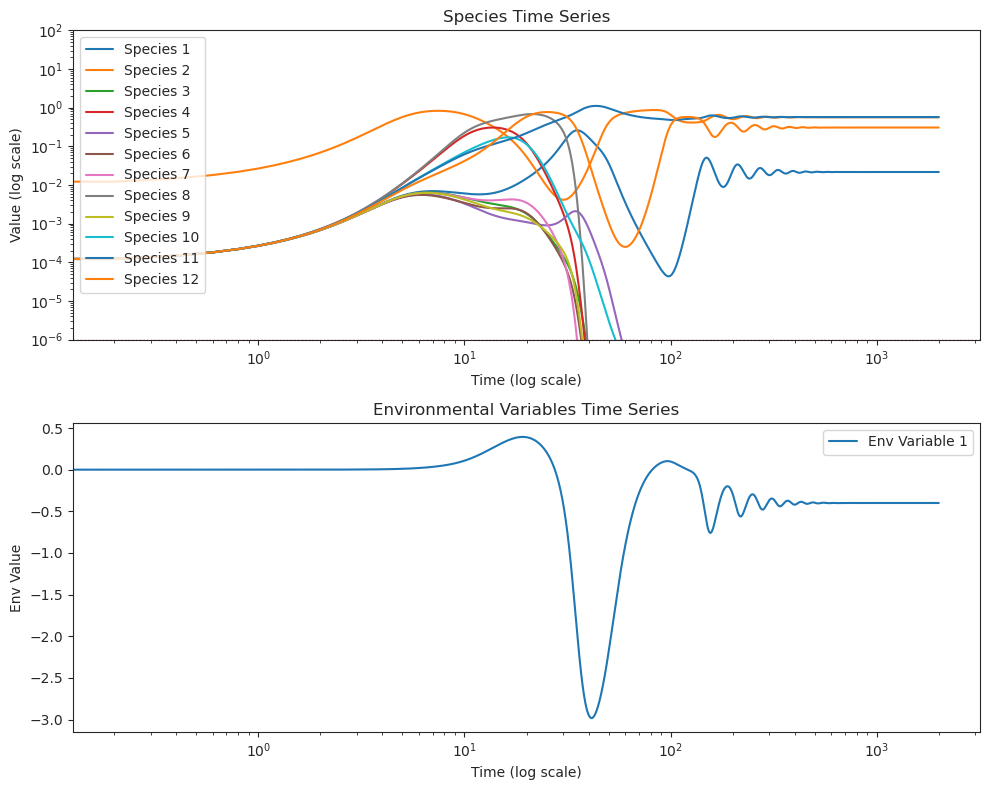

{'species': array([ 2.16528982e-002,  5.63911996e-001,  1.93673678e-313,
        1.52814105e-025,  2.38396620e-076, -7.52751690e-306,
        3.95316892e-257,  7.25480811e-082, -9.10992076e-289,
       -9.23302823e-195,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


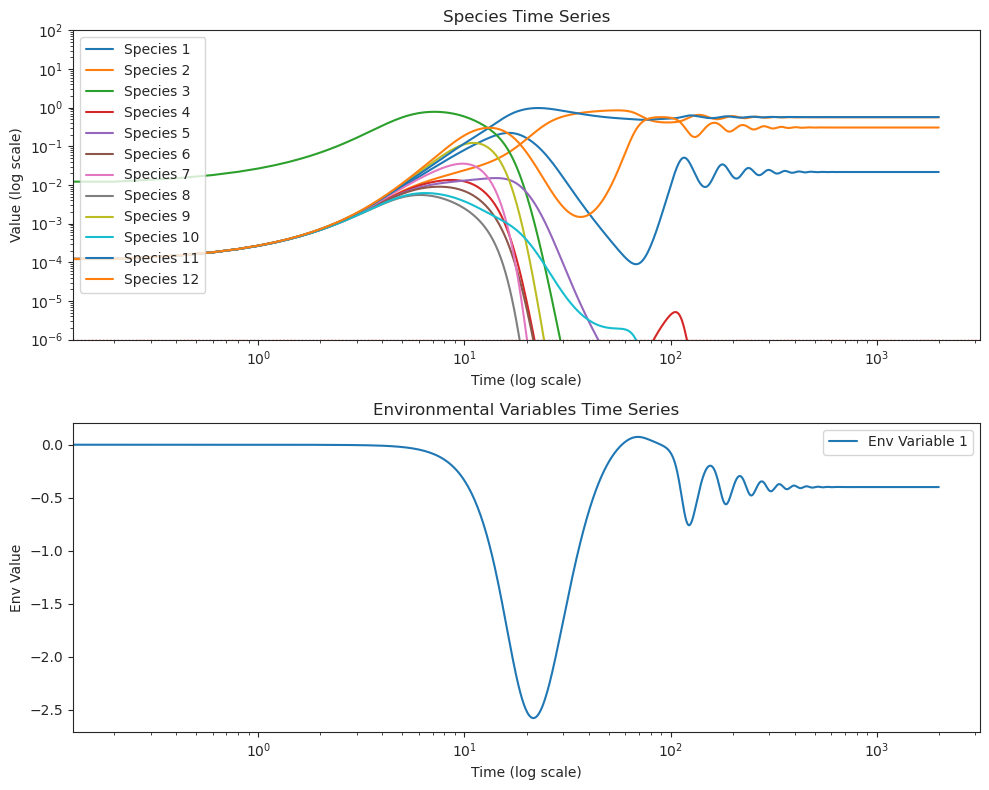

{'species': array([ 2.16528982e-002,  5.63911997e-001, -3.70328345e-313,
        1.21007411e-022,  3.29971501e-076,  4.07010684e-311,
       -9.67877981e-256,  1.58279864e-084, -2.29010429e-292,
       -1.71923822e-194,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


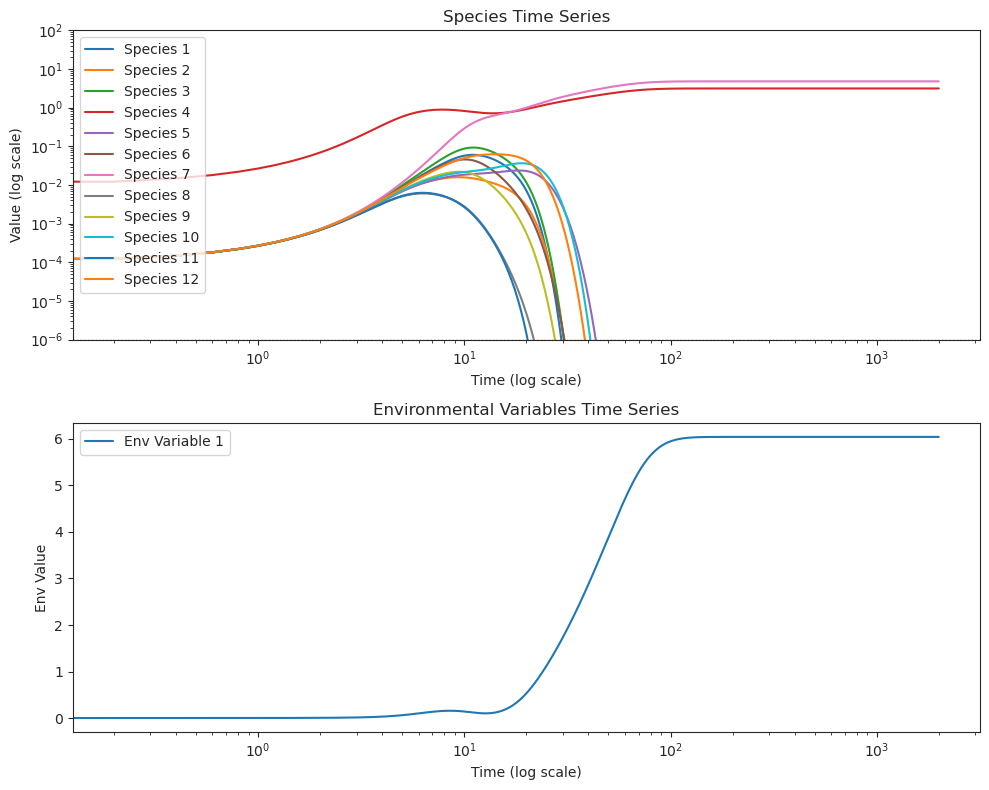

{'species': array([ 1.85258994e-50,  2.72024854e-51, -1.95459337e-50,  3.13625607e+00,
       -2.70780102e-44,  1.88632816e-49,  4.79107529e+00,  1.75443402e-56,
       -1.07342711e-52, -2.00134643e-42,  4.37876051e-39, -1.37293020e-43,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}


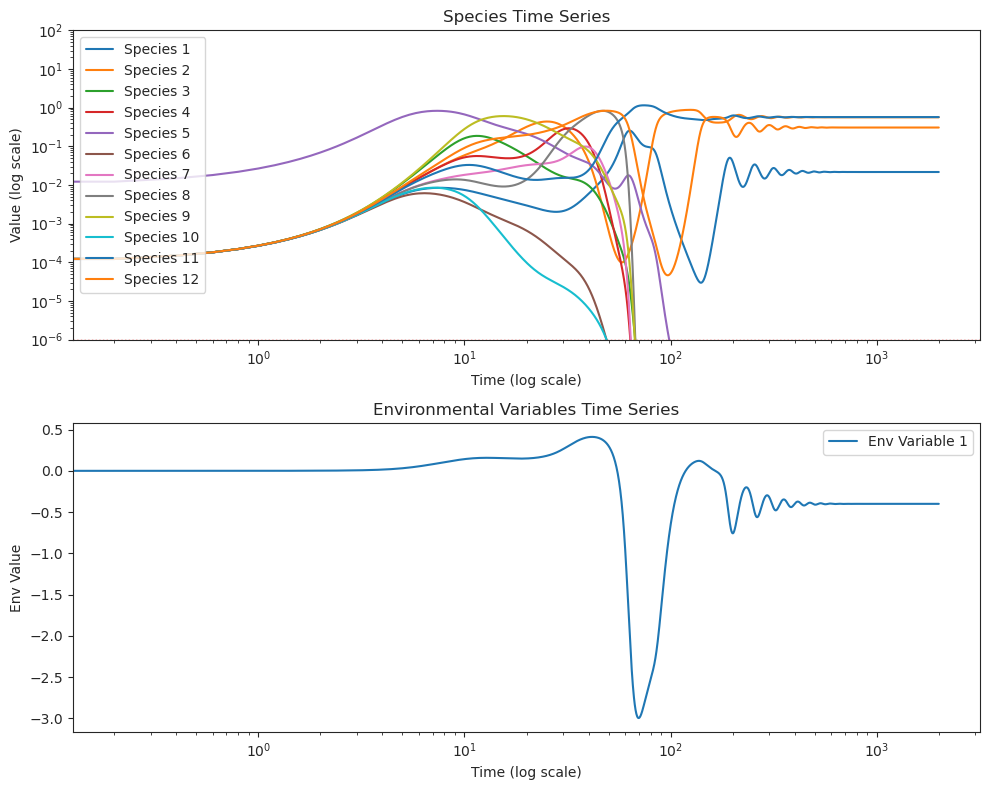

{'species': array([ 2.16528982e-002,  5.63911996e-001, -2.86328100e-254,
        8.09203303e-030,  1.26484362e-073,  8.81023243e-245,
        1.56940994e-234, -1.77949139e-075, -3.60014820e-225,
       -2.93777146e-157,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


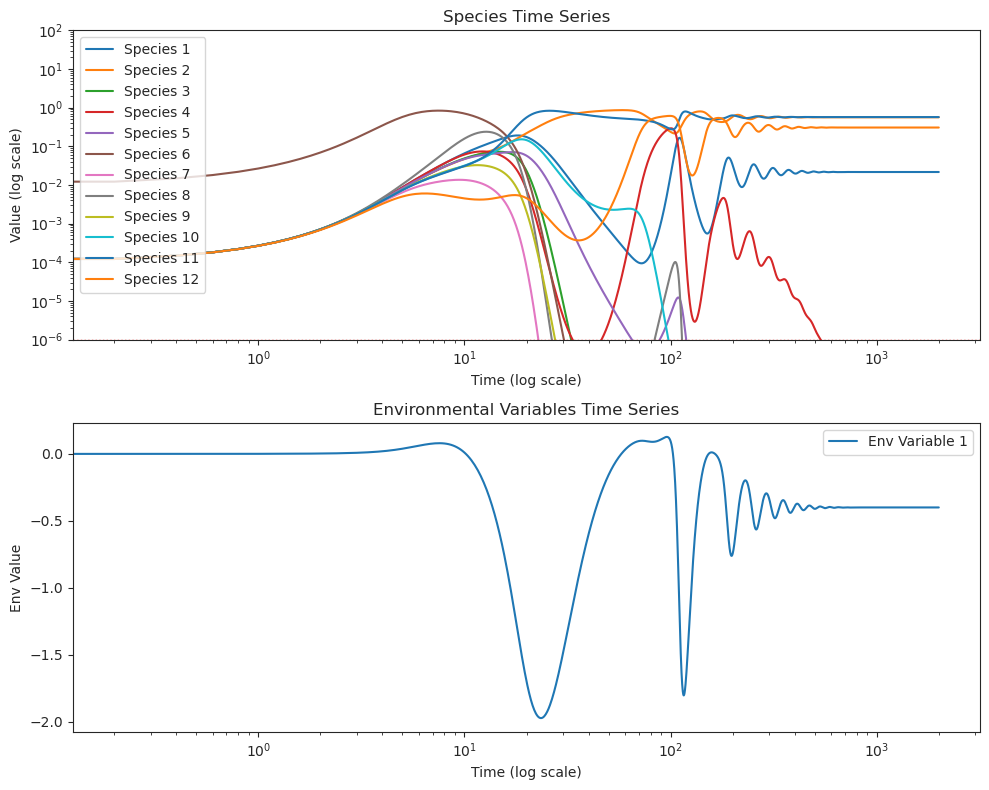

{'species': array([ 2.16528982e-002,  5.63911996e-001, -6.23480787e-254,
        4.55584597e-019,  1.98477221e-074,  3.19423410e-241,
       -1.69880000e-248,  2.44038515e-077, -1.11698914e-225,
        5.00254922e-153,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


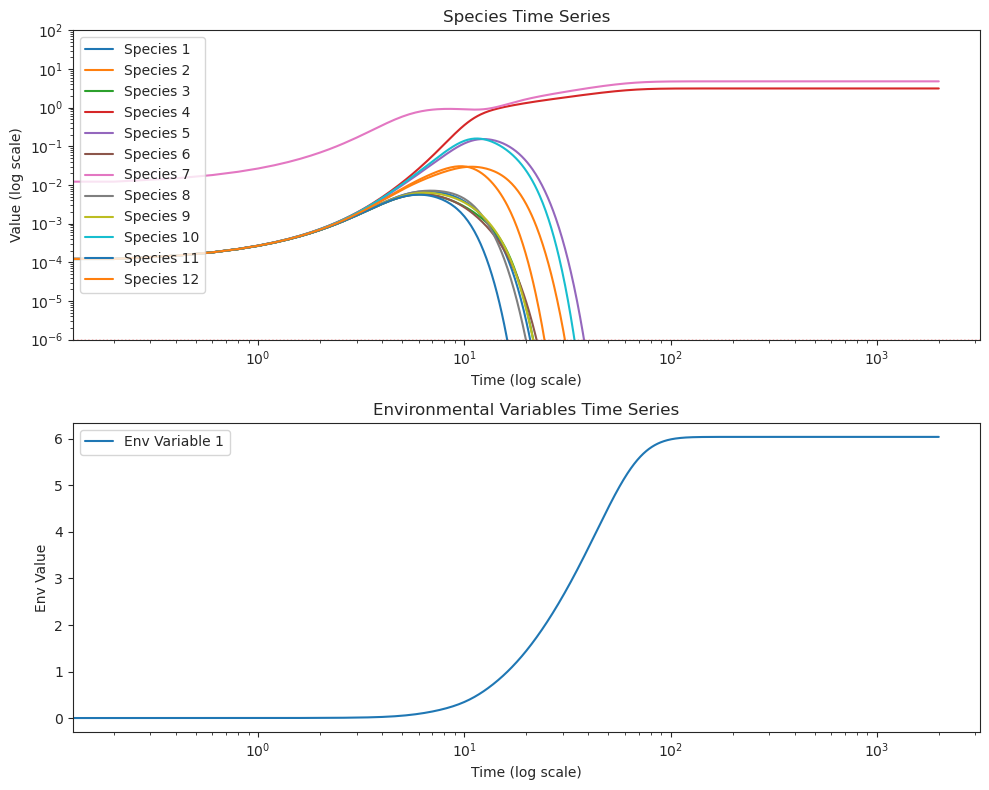

{'species': array([ 3.18126970e-83, -8.79030468e-82,  1.51393060e-84,  3.13625607e+00,
        9.53399932e-58,  1.69383436e-77,  4.79107529e+00,  7.65953230e-87,
        8.00687018e-84, -3.31370276e-64, -2.53090225e-33, -1.47926748e-66,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}


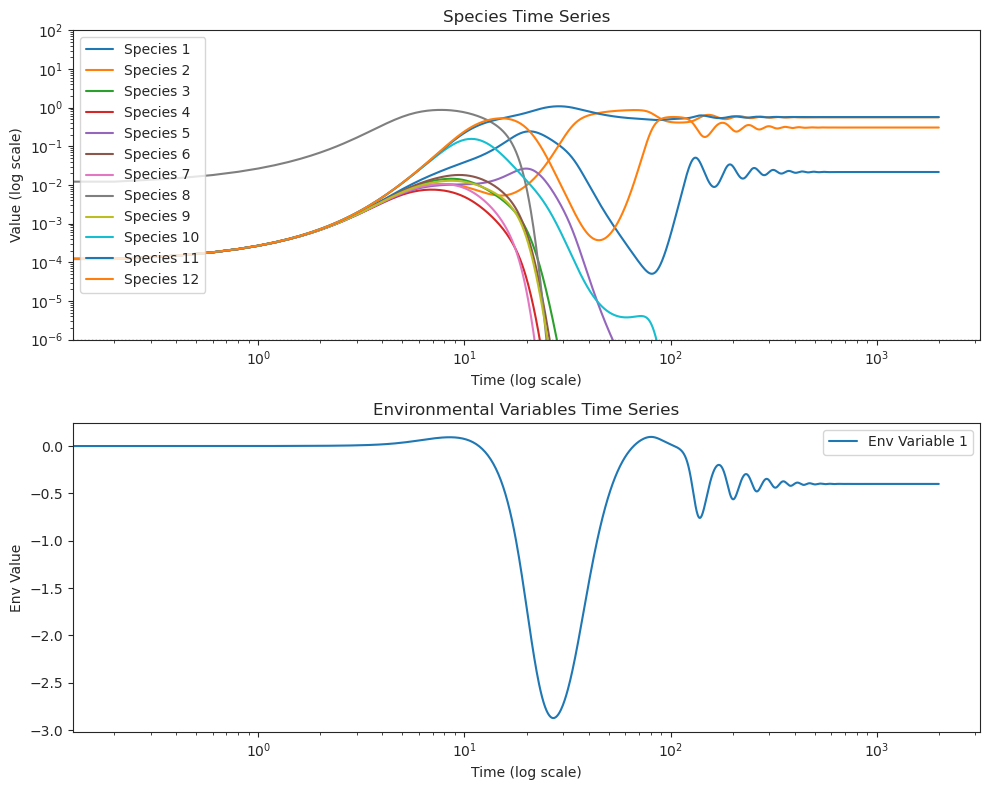

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.92940963e-297,
        1.04453531e-025,  9.76798500e-076, -8.26238001e-290,
       -2.82598466e-250, -1.01699702e-081,  1.55657416e-277,
        2.42227442e-190,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


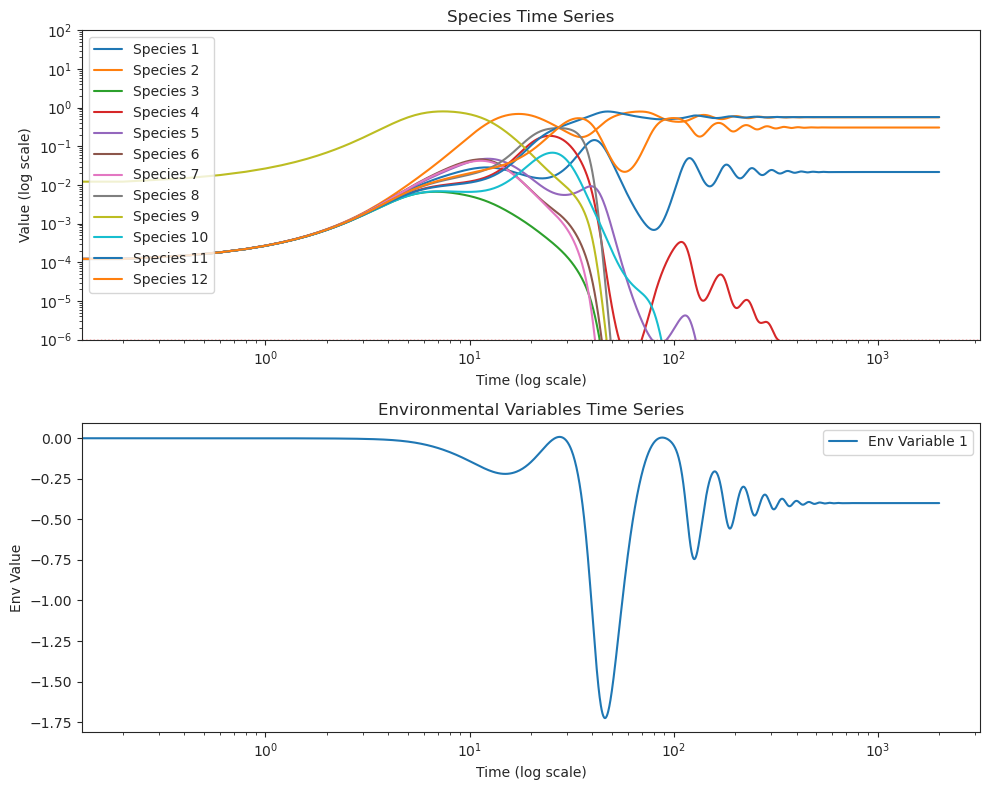

{'species': array([ 2.16528982e-002,  5.63911997e-001, -5.17821713e-303,
        8.98891983e-021,  2.67197800e-075, -1.24547097e-296,
       -1.63435652e-259,  5.58859845e-079,  5.54368394e-283,
       -6.77028571e-191,  5.70365502e-001,  3.06254232e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


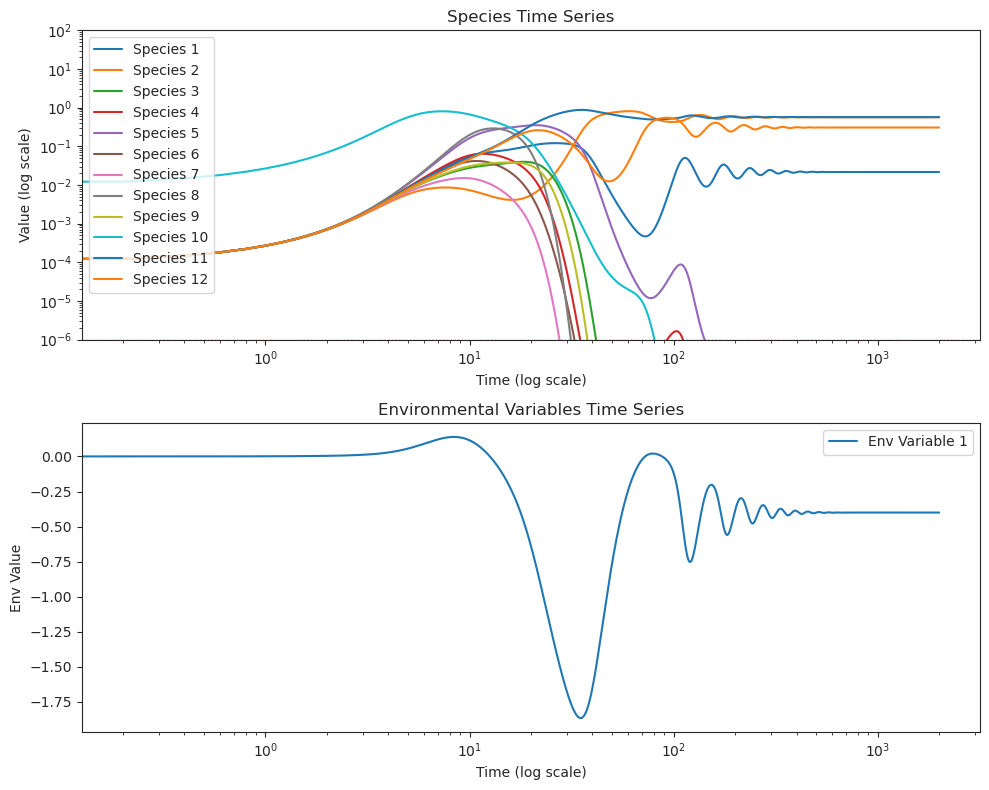

{'species': array([ 2.16528982e-002,  5.63911997e-001, -1.85775031e-295,
        3.83653182e-023,  3.84052284e-074, -1.52072359e-291,
       -6.90170335e-259,  6.89603267e-084, -1.34838939e-280,
        1.99326279e-191,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


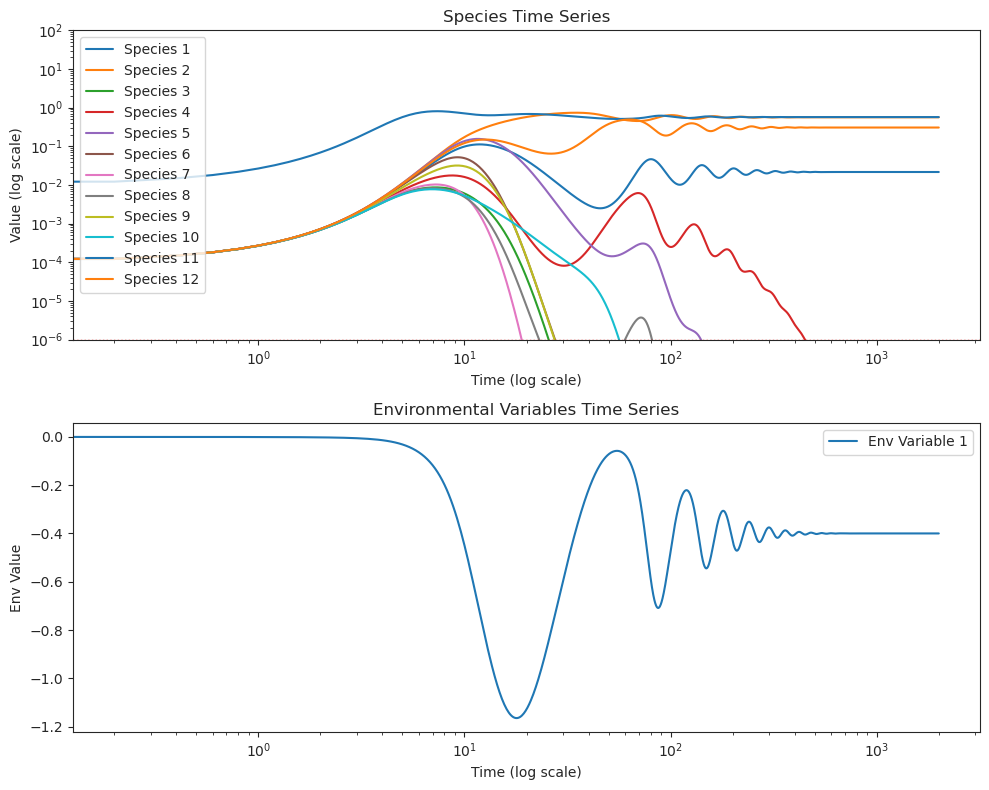

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.20149270e-246,
        8.61669833e-020,  6.48798485e-071,  2.49929571e-234,
       -7.22697870e-223,  5.76002573e-075, -6.13675973e-218,
        1.62446847e-149,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


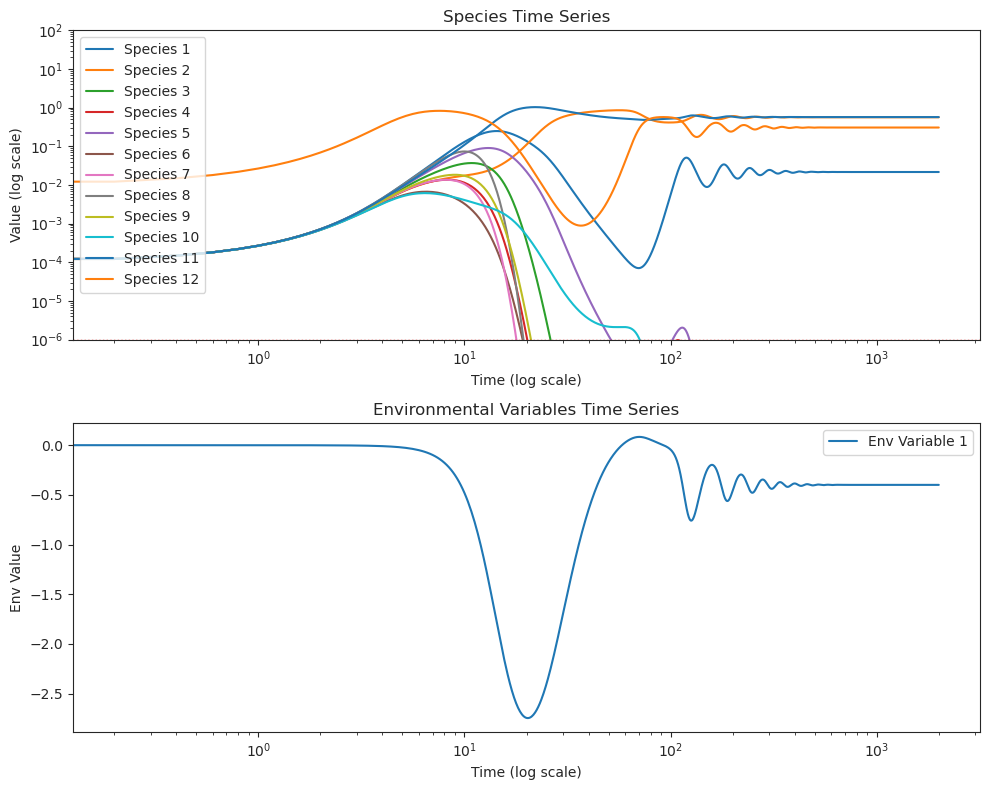

{'species': array([ 2.16528982e-002,  5.63911997e-001,  4.19320614e-266,
        2.40848539e-023, -6.27978659e-073, -6.83292958e-259,
        1.18156904e-226, -1.56781555e-078,  1.51866700e-247,
       -2.32191679e-165,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


NameError: name 'to_plot' is not defined

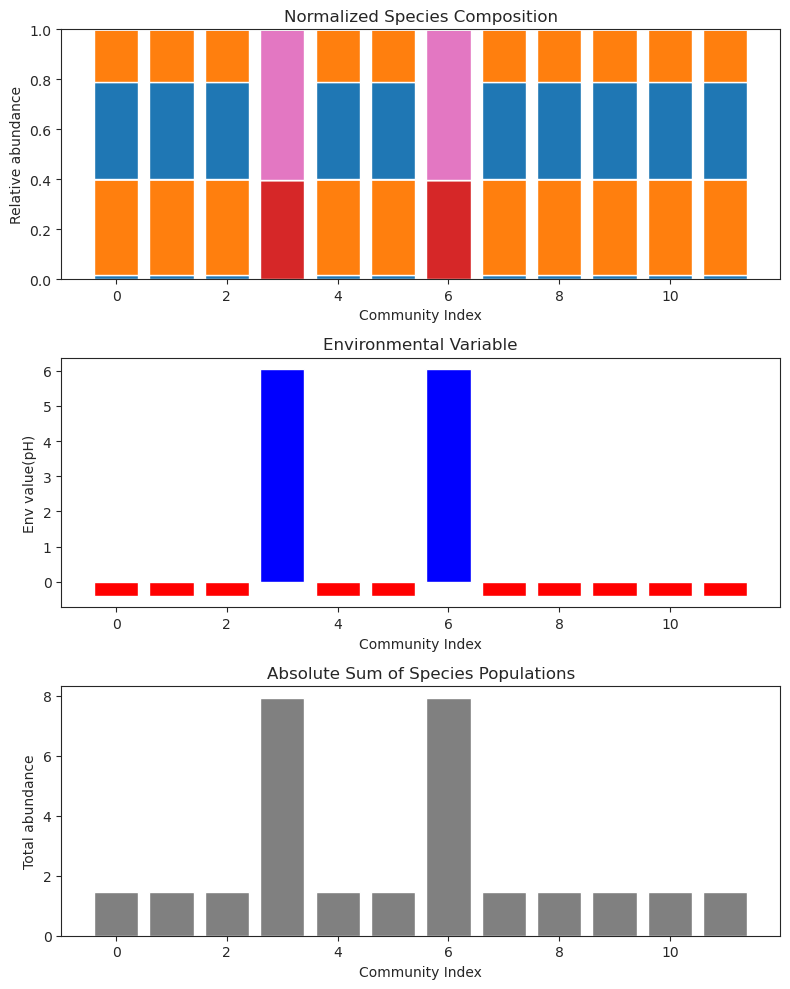

In [35]:
    
    label="test"
    sys
    ##
    y_out_list=[]

    for i in range(12):
        y0_species=one_hot_vector(12,i)
        y0_env=[0]
        t=np.linspace(0, 2000, 10000)

        y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

        y_out_list.append(y_out)
    
    num_datasets = len(y_out_list)

    # Prepare subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    # Data for plots
    species_matrix = np.array([y_out['species'] for y_out in y_out_list])
    env_data = np.array([y_out['env'][0] for y_out in y_out_list])  # Assuming env is a single-element array

    # Normalize species data
    species_matrix = np.maximum(species_matrix, 0)  # Removing negative values for normalization
    species_sums = np.sum(species_matrix, axis=1, keepdims=True)
    normalized_species = species_matrix / species_sums
    
    # Absolute sums of species data (sum across all species for each dataset)
    absolute_sums = np.sum(species_matrix, axis=1)
    
    # Plotting species composition as stacked bars
    bottom_values = np.zeros(num_datasets)  # Initial bottom values are zeros
    for i in range(normalized_species.shape[1]):  # Loop through each species
        axs[0].bar(np.arange(num_datasets), normalized_species[:, i], bottom=bottom_values, label=f'Species {i+1}')
        bottom_values += normalized_species[:, i]  # Update bottom values for stacking

    axs[0].set_title('Normalized Species Composition')
    axs[0].set_xlabel('Community Index')
    axs[0].set_ylabel('Relative abundance')
    #axs[0].legend()

    # Plotting environmental factors
    colors = ['blue' if x > 0 else 'red' for x in env_data]  # Determine color based on sign of value
    axs[1].bar(np.arange(num_datasets), env_data, color=colors, width=0.8)
    axs[1].set_title('Environmental Variable')
    axs[1].set_xlabel('Community Index')
    axs[1].set_ylabel('Env value(pH)')

    # Plotting absolute sums of species data
    axs[2].bar(np.arange(num_datasets), absolute_sums, color='gray', width=0.8)
    axs[2].set_title('Absolute Sum of Species Populations')
    axs[2].set_xlabel('Community Index')
    axs[2].set_ylabel('Total abundance')

    plt.tight_layout()
    
    if to_plot:
        plt.savefig()
        
        
    plt.show()


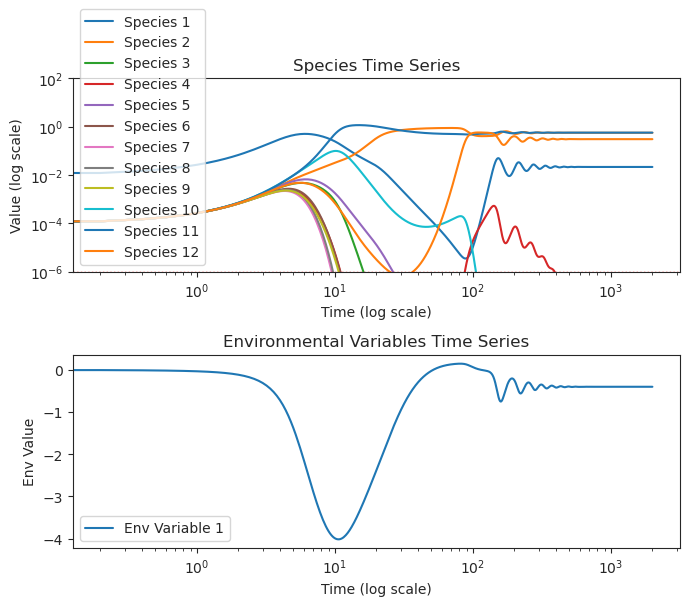

{'species': array([ 2.16528982e-002,  5.63911996e-001,  6.93558402e-310,
        2.59518900e-020,  5.00885903e-077, -6.30431388e-302,
        2.34181456e-261, -9.95264675e-080,  9.15559681e-293,
        1.50478388e-189,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


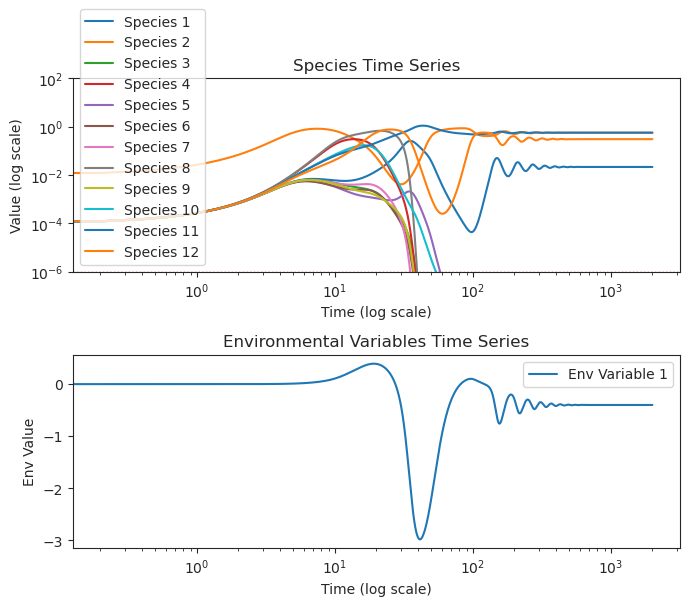

{'species': array([ 2.16528982e-002,  5.63911996e-001,  1.93673678e-313,
        1.52814105e-025,  2.38396620e-076, -7.52751690e-306,
        3.95316892e-257,  7.25480811e-082, -9.10992076e-289,
       -9.23302823e-195,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


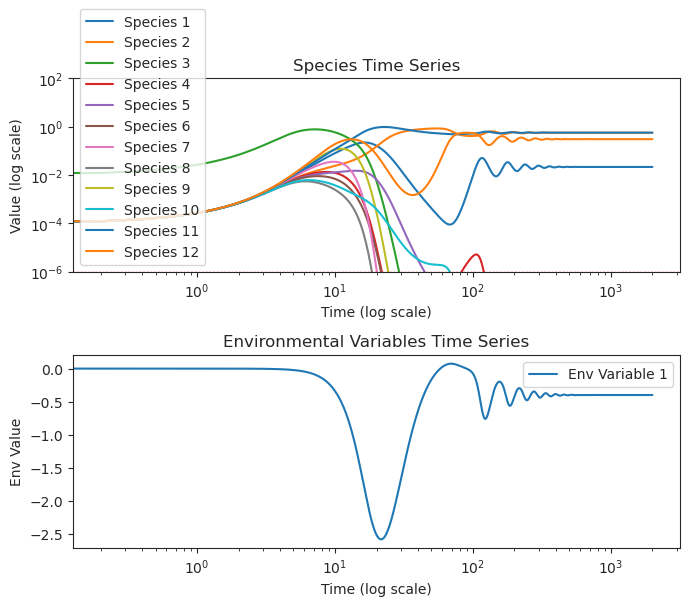

{'species': array([ 2.16528982e-002,  5.63911997e-001, -3.70328345e-313,
        1.21007411e-022,  3.29971501e-076,  4.07010684e-311,
       -9.67877981e-256,  1.58279864e-084, -2.29010429e-292,
       -1.71923822e-194,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


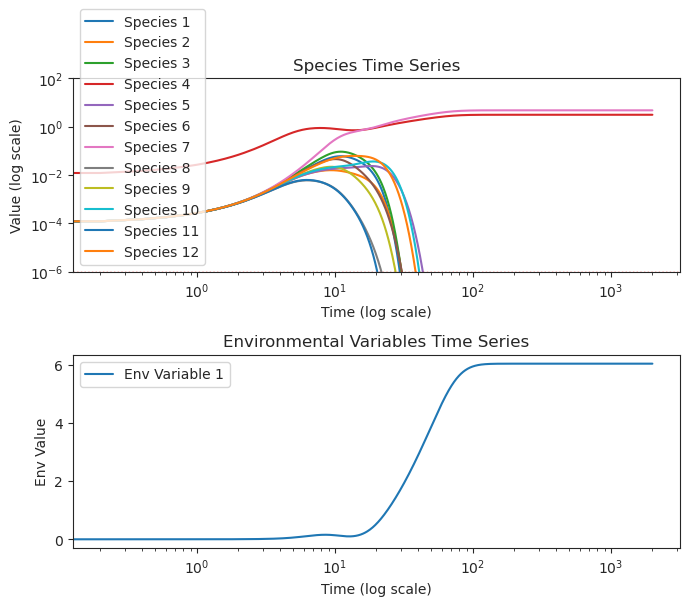

{'species': array([ 1.85258994e-50,  2.72024854e-51, -1.95459337e-50,  3.13625607e+00,
       -2.70780102e-44,  1.88632816e-49,  4.79107529e+00,  1.75443402e-56,
       -1.07342711e-52, -2.00134643e-42,  4.37876051e-39, -1.37293020e-43,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}


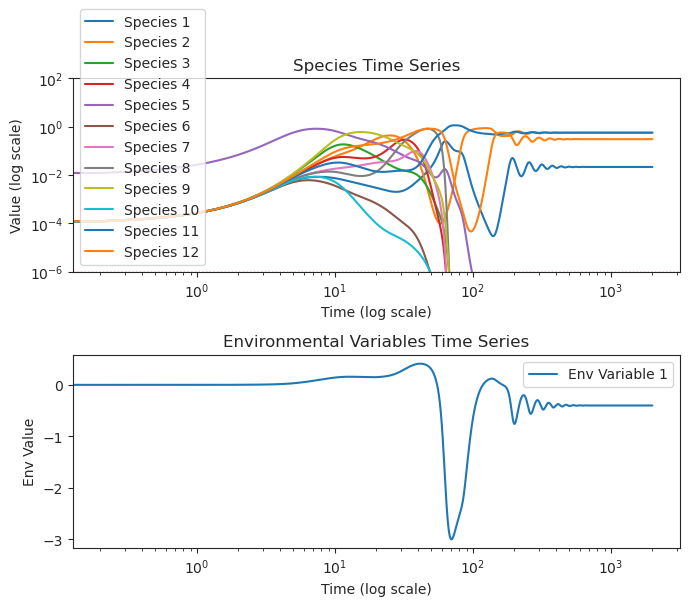

{'species': array([ 2.16528982e-002,  5.63911996e-001, -2.86328100e-254,
        8.09203303e-030,  1.26484362e-073,  8.81023243e-245,
        1.56940994e-234, -1.77949139e-075, -3.60014820e-225,
       -2.93777146e-157,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


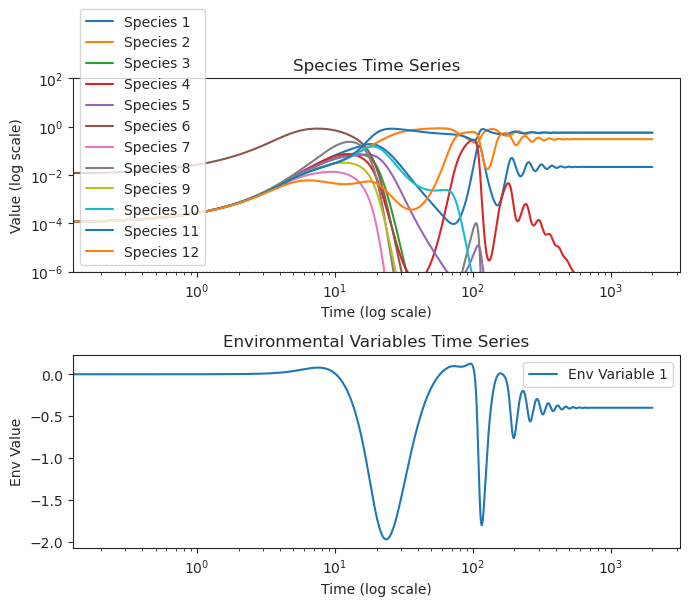

{'species': array([ 2.16528982e-002,  5.63911996e-001, -6.23480787e-254,
        4.55584597e-019,  1.98477221e-074,  3.19423410e-241,
       -1.69880000e-248,  2.44038515e-077, -1.11698914e-225,
        5.00254922e-153,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


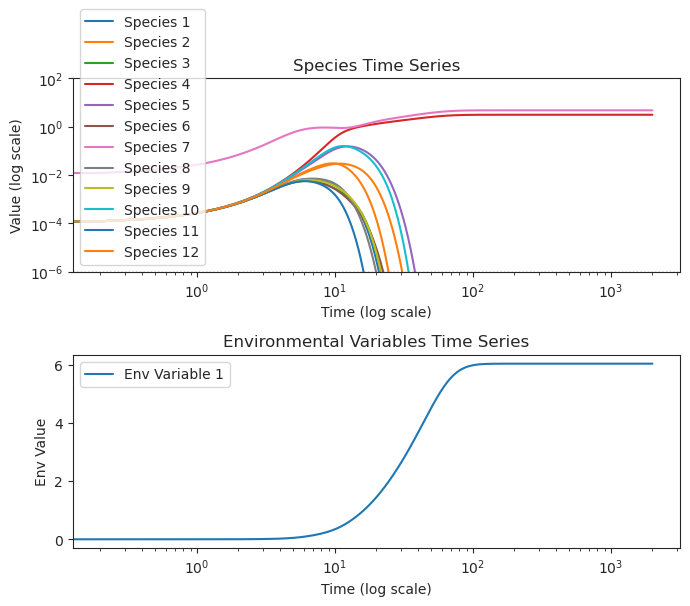

{'species': array([ 3.18126970e-83, -8.79030468e-82,  1.51393060e-84,  3.13625607e+00,
        9.53399932e-58,  1.69383436e-77,  4.79107529e+00,  7.65953230e-87,
        8.00687018e-84, -3.31370276e-64, -2.53090225e-33, -1.47926748e-66,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}


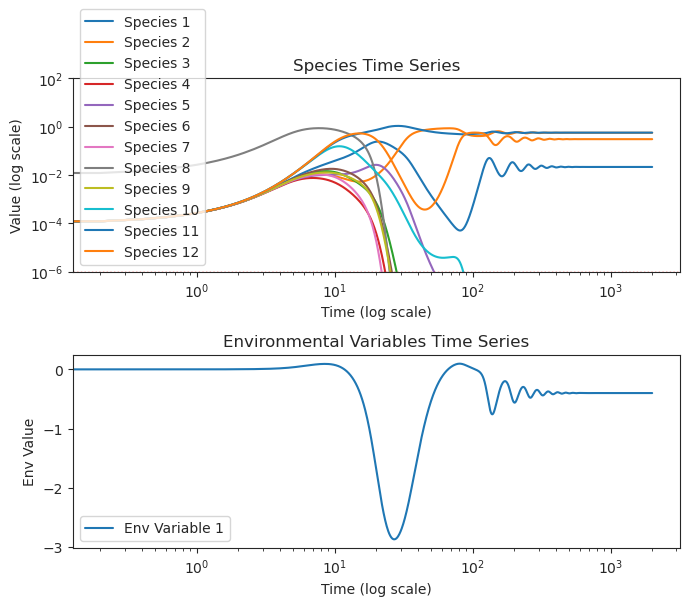

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.92940963e-297,
        1.04453531e-025,  9.76798500e-076, -8.26238001e-290,
       -2.82598466e-250, -1.01699702e-081,  1.55657416e-277,
        2.42227442e-190,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


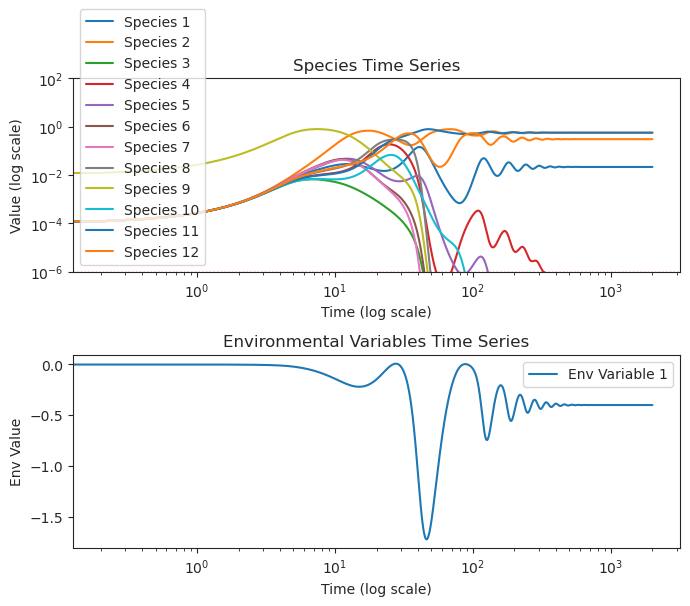

{'species': array([ 2.16528982e-002,  5.63911997e-001, -5.17821713e-303,
        8.98891983e-021,  2.67197800e-075, -1.24547097e-296,
       -1.63435652e-259,  5.58859845e-079,  5.54368394e-283,
       -6.77028571e-191,  5.70365502e-001,  3.06254232e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


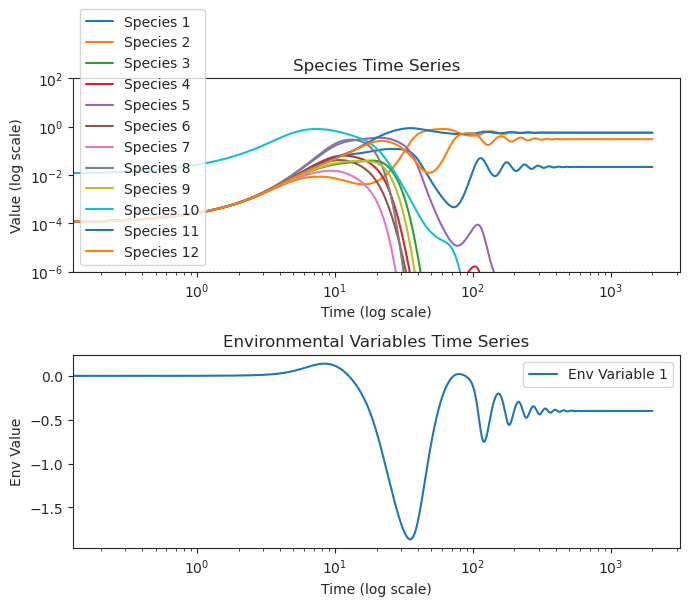

{'species': array([ 2.16528982e-002,  5.63911997e-001, -1.85775031e-295,
        3.83653182e-023,  3.84052284e-074, -1.52072359e-291,
       -6.90170335e-259,  6.89603267e-084, -1.34838939e-280,
        1.99326279e-191,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


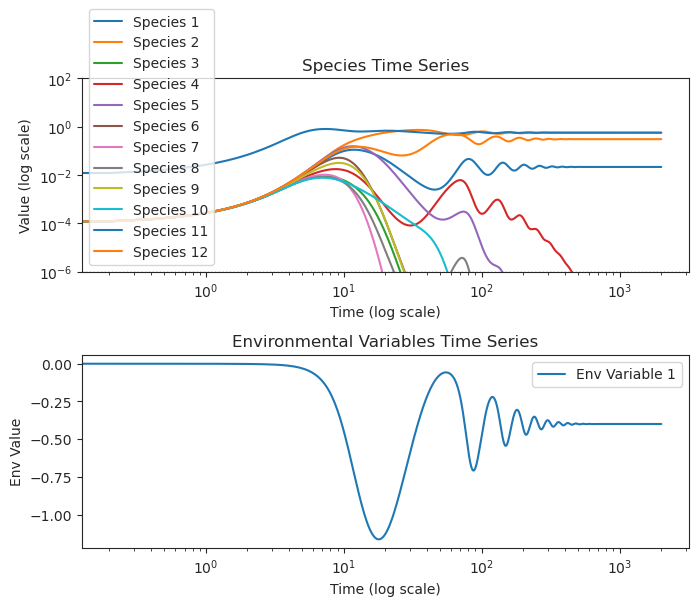

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.20149270e-246,
        8.61669833e-020,  6.48798485e-071,  2.49929571e-234,
       -7.22697870e-223,  5.76002573e-075, -6.13675973e-218,
        1.62446847e-149,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


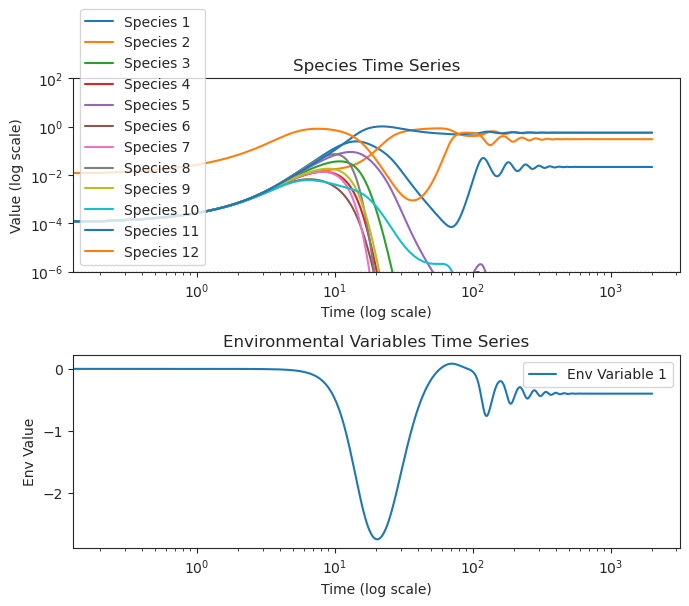

{'species': array([ 2.16528982e-002,  5.63911997e-001,  4.19320614e-266,
        2.40848539e-023, -6.27978659e-073, -6.83292958e-259,
        1.18156904e-226, -1.56781555e-078,  1.51866700e-247,
       -2.32191679e-165,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}


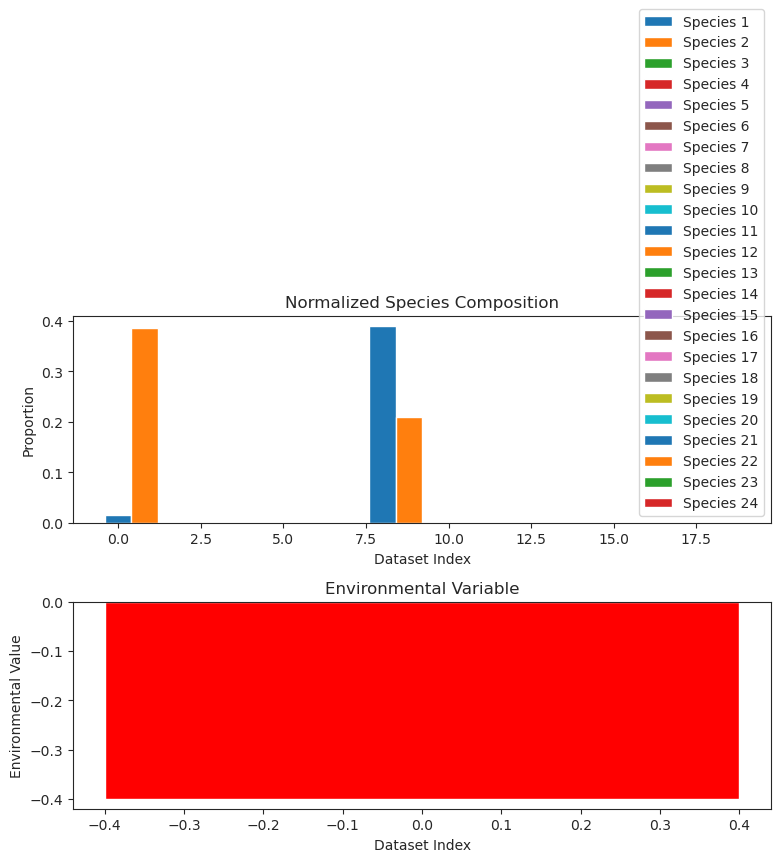

In [39]:
plot_states_from_cfg(system_config)

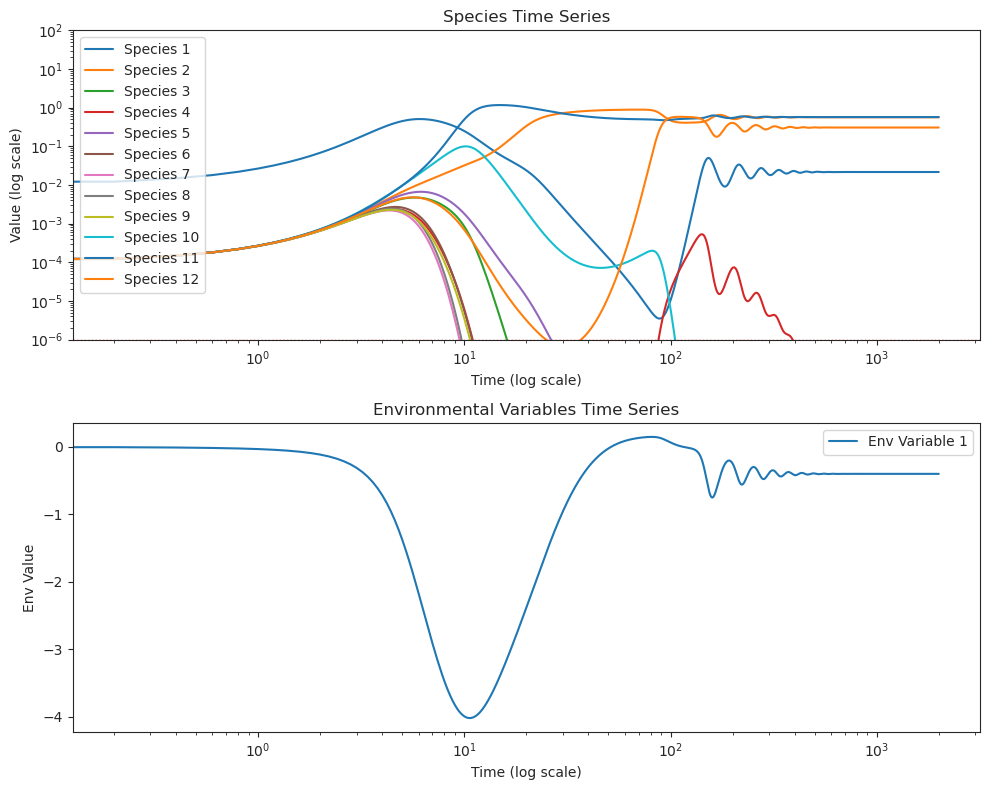

{'species': array([ 2.16528982e-002,  5.63911996e-001,  6.93558402e-310,
        2.59518900e-020,  5.00885903e-077, -6.30431388e-302,
        2.34181456e-261, -9.95264675e-080,  9.15559681e-293,
        1.50478388e-189,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.4621846289628624 -0.399781927571416


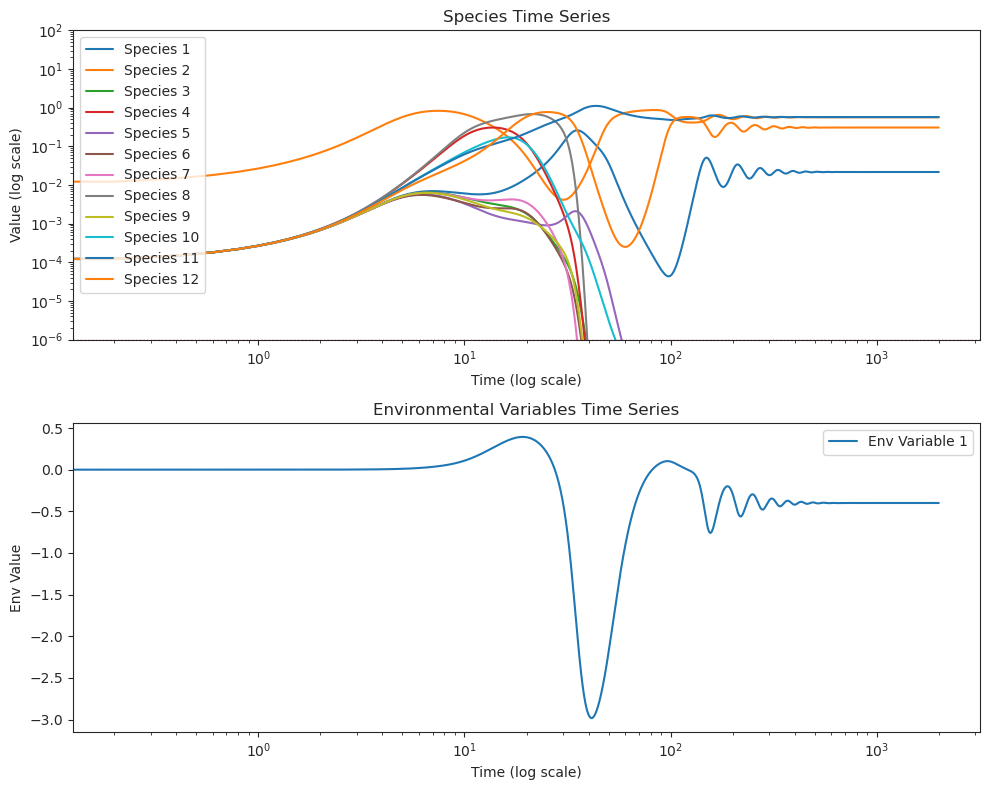

{'species': array([ 2.16528982e-002,  5.63911996e-001,  1.93673678e-313,
        1.52814105e-025,  2.38396620e-076, -7.52751690e-306,
        3.95316892e-257,  7.25480811e-082, -9.10992076e-289,
       -9.23302823e-195,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.462184628955059 -0.39978192769574983


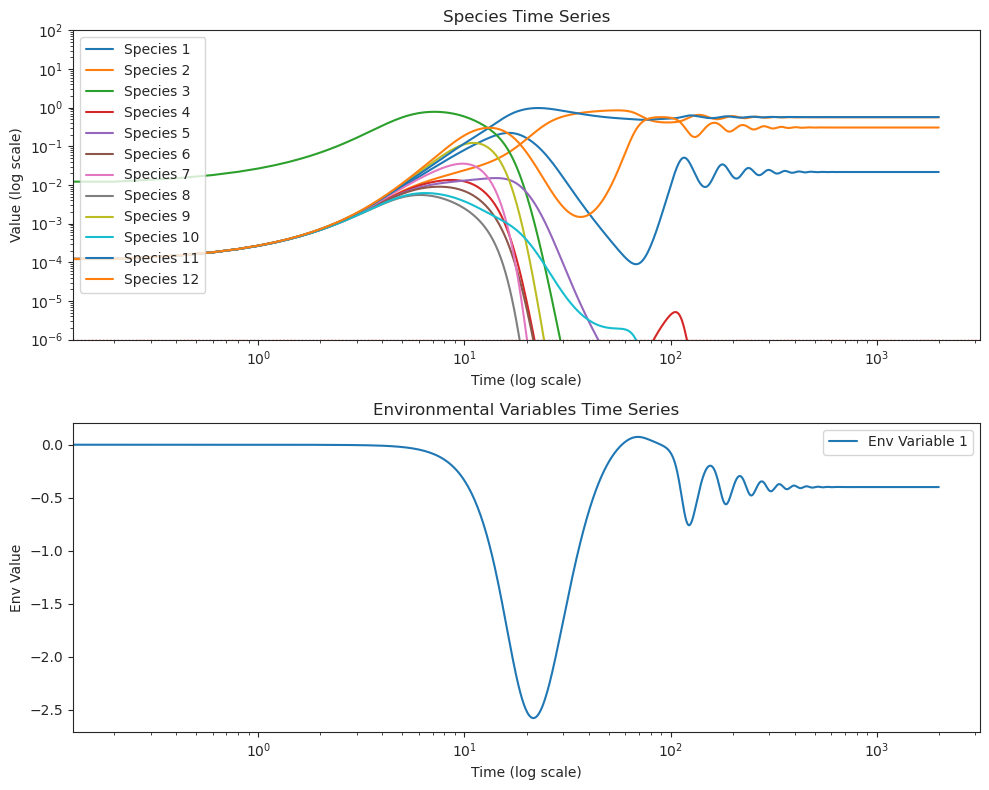

{'species': array([ 2.16528982e-002,  5.63911997e-001, -3.70328345e-313,
        1.21007411e-022,  3.29971501e-076,  4.07010684e-311,
       -9.67877981e-256,  1.58279864e-084, -2.29010429e-292,
       -1.71923822e-194,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.462184628920911 -0.3997819279016769


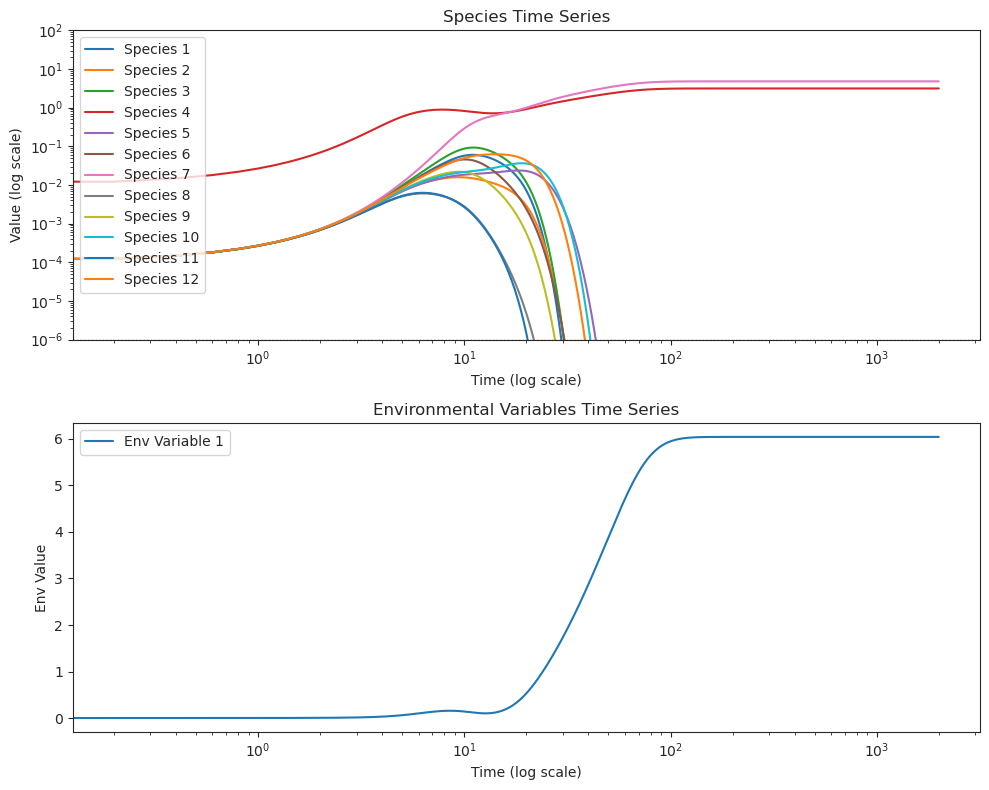

{'species': array([ 1.85258994e-50,  2.72024854e-51, -1.95459337e-50,  3.13625607e+00,
       -2.70780102e-44,  1.88632816e-49,  4.79107529e+00,  1.75443402e-56,
       -1.07342711e-52, -2.00134643e-42,  4.37876051e-39, -1.37293020e-43,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}
7.9273313529935026 6.043700929487666


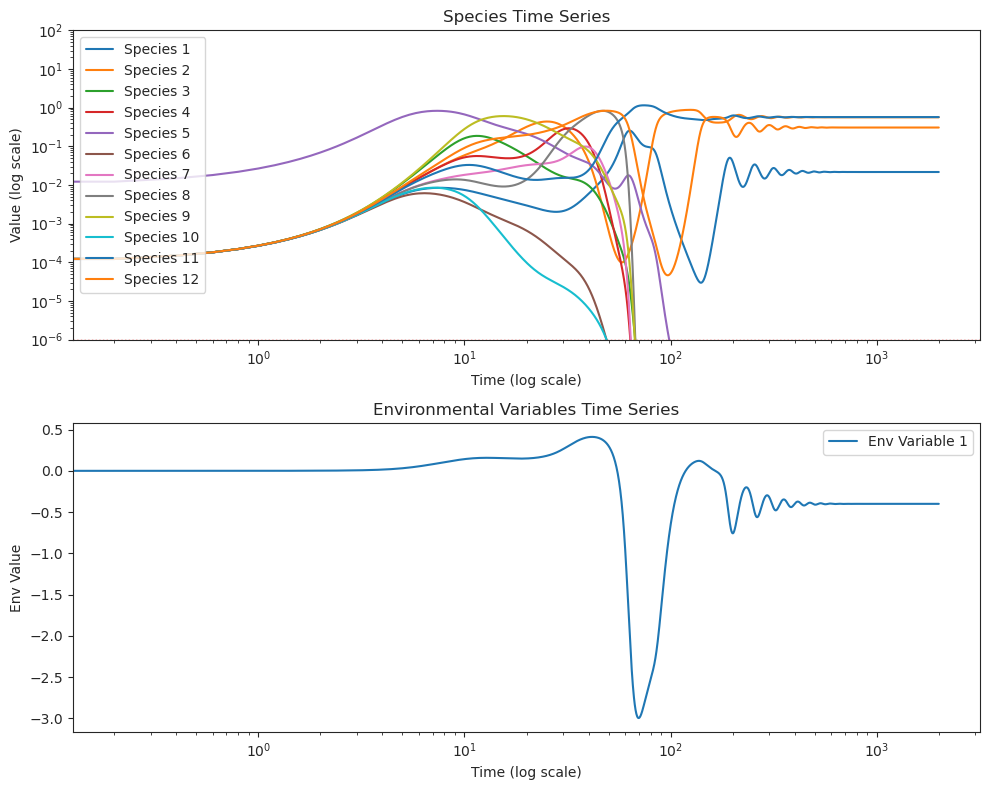

{'species': array([ 2.16528982e-002,  5.63911996e-001, -2.86328100e-254,
        8.09203303e-030,  1.26484362e-073,  8.81023243e-245,
        1.56940994e-234, -1.77949139e-075, -3.60014820e-225,
       -2.93777146e-157,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.4621846289043887 -0.39978192828576103


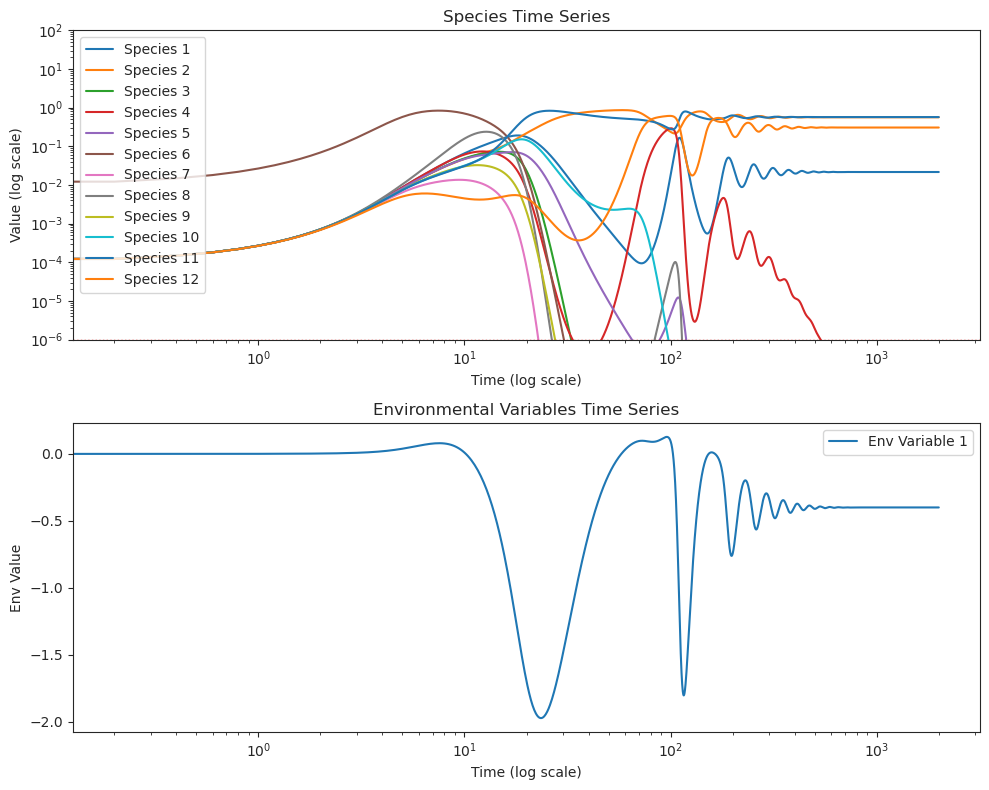

{'species': array([ 2.16528982e-002,  5.63911996e-001, -6.23480787e-254,
        4.55584597e-019,  1.98477221e-074,  3.19423410e-241,
       -1.69880000e-248,  2.44038515e-077, -1.11698914e-225,
        5.00254922e-153,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.462184628903769 -0.3997819282625494


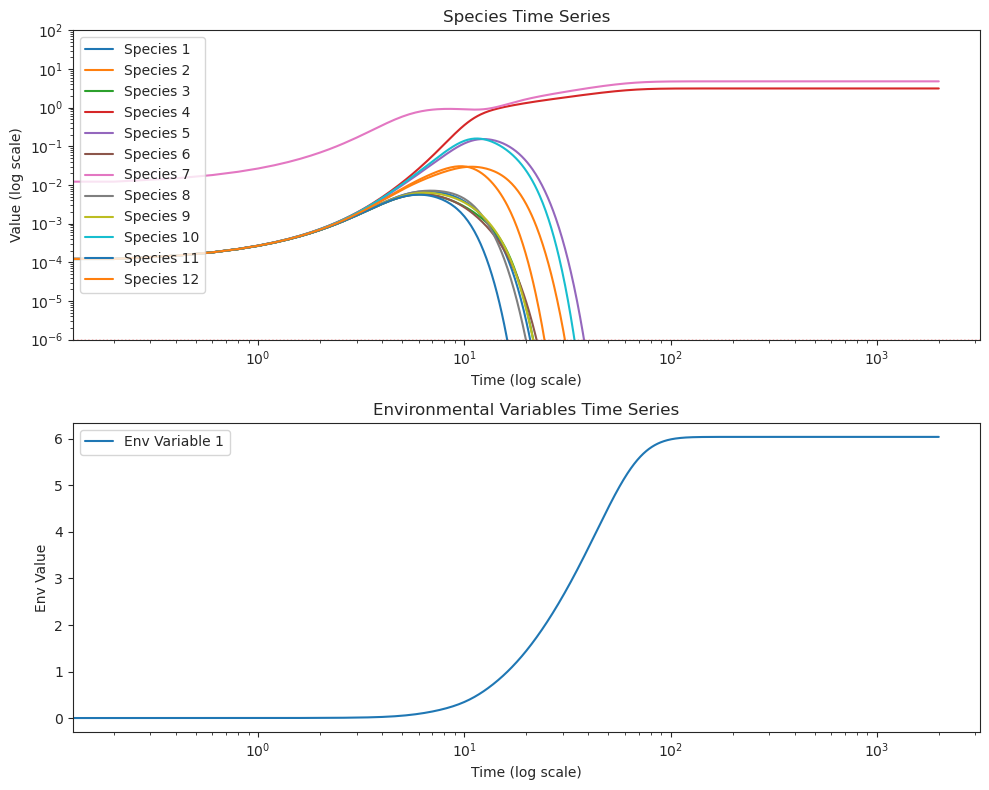

{'species': array([ 3.18126970e-83, -8.79030468e-82,  1.51393060e-84,  3.13625607e+00,
        9.53399932e-58,  1.69383436e-77,  4.79107529e+00,  7.65953230e-87,
        8.00687018e-84, -3.31370276e-64, -2.53090225e-33, -1.47926748e-66,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([6.04370093])}
7.927331352993507 6.04370092948767


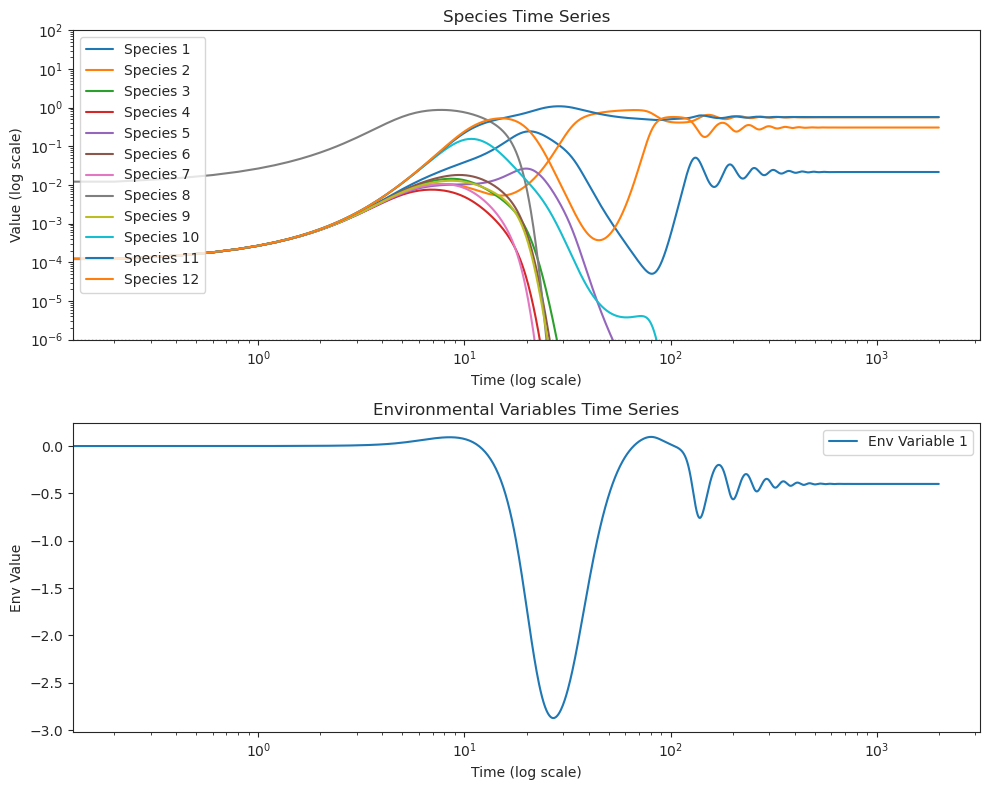

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.92940963e-297,
        1.04453531e-025,  9.76798500e-076, -8.26238001e-290,
       -2.82598466e-250, -1.01699702e-081,  1.55657416e-277,
        2.42227442e-190,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.4621846288969325 -0.39978192835732135


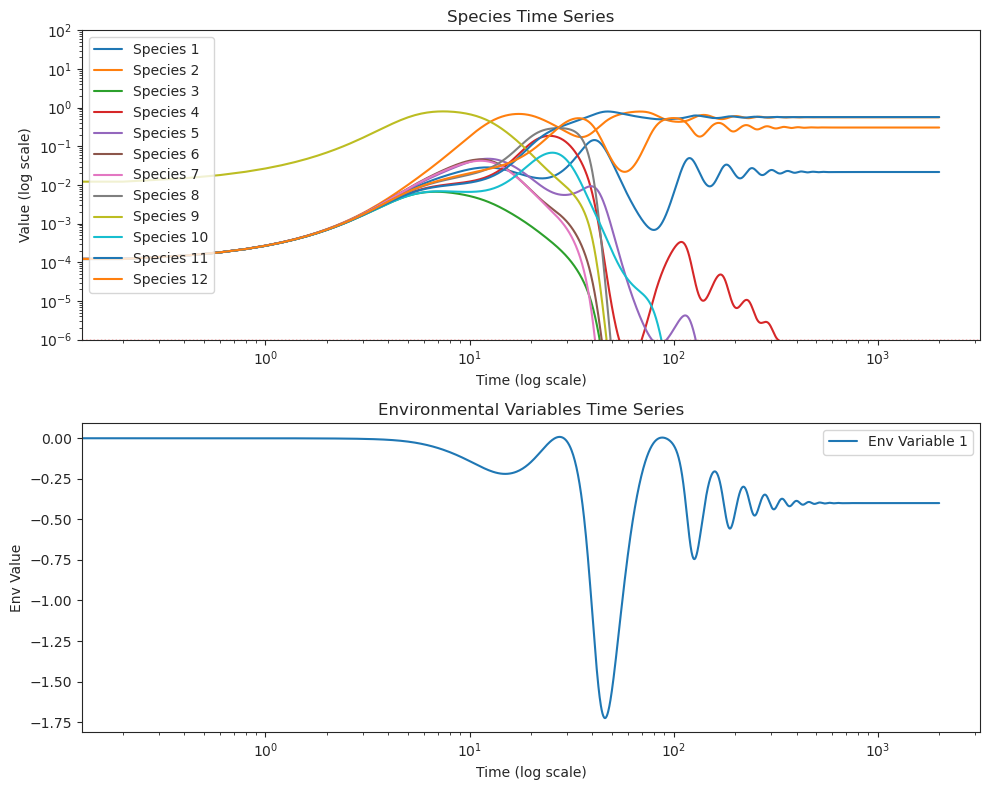

{'species': array([ 2.16528982e-002,  5.63911997e-001, -5.17821713e-303,
        8.98891983e-021,  2.67197800e-075, -1.24547097e-296,
       -1.63435652e-259,  5.58859845e-079,  5.54368394e-283,
       -6.77028571e-191,  5.70365502e-001,  3.06254232e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.4621846288910936 -0.39978192809720475


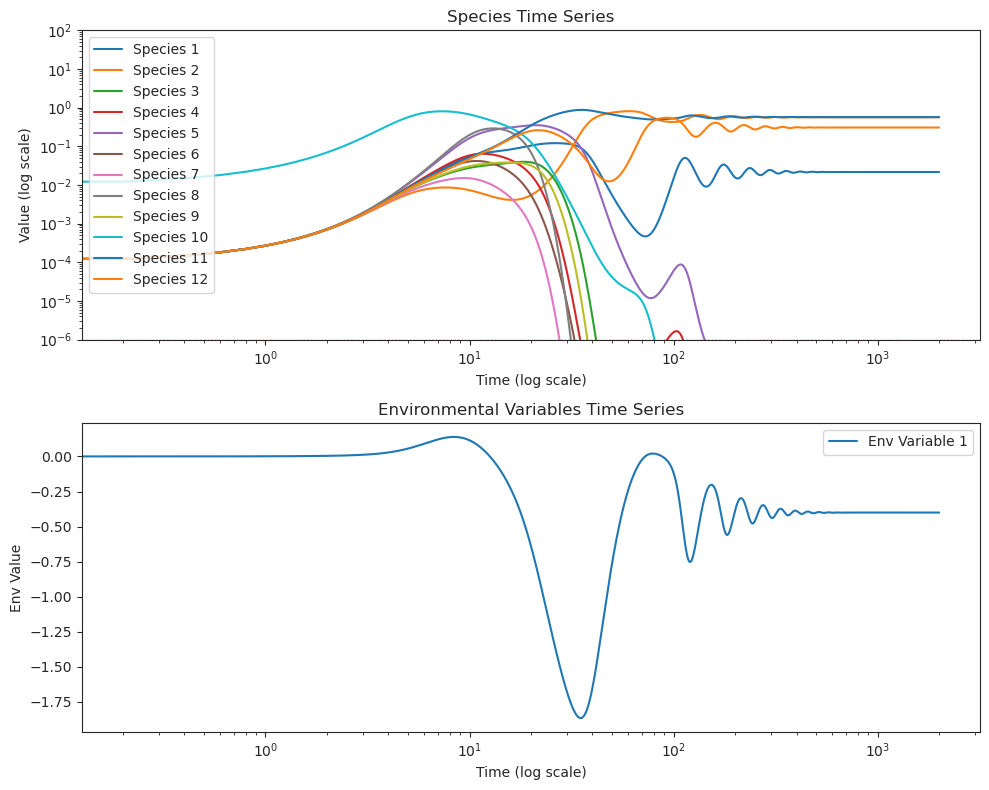

{'species': array([ 2.16528982e-002,  5.63911997e-001, -1.85775031e-295,
        3.83653182e-023,  3.84052284e-074, -1.52072359e-291,
       -6.90170335e-259,  6.89603267e-084, -1.34838939e-280,
        1.99326279e-191,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.4621846289322877 -0.39978192774625293


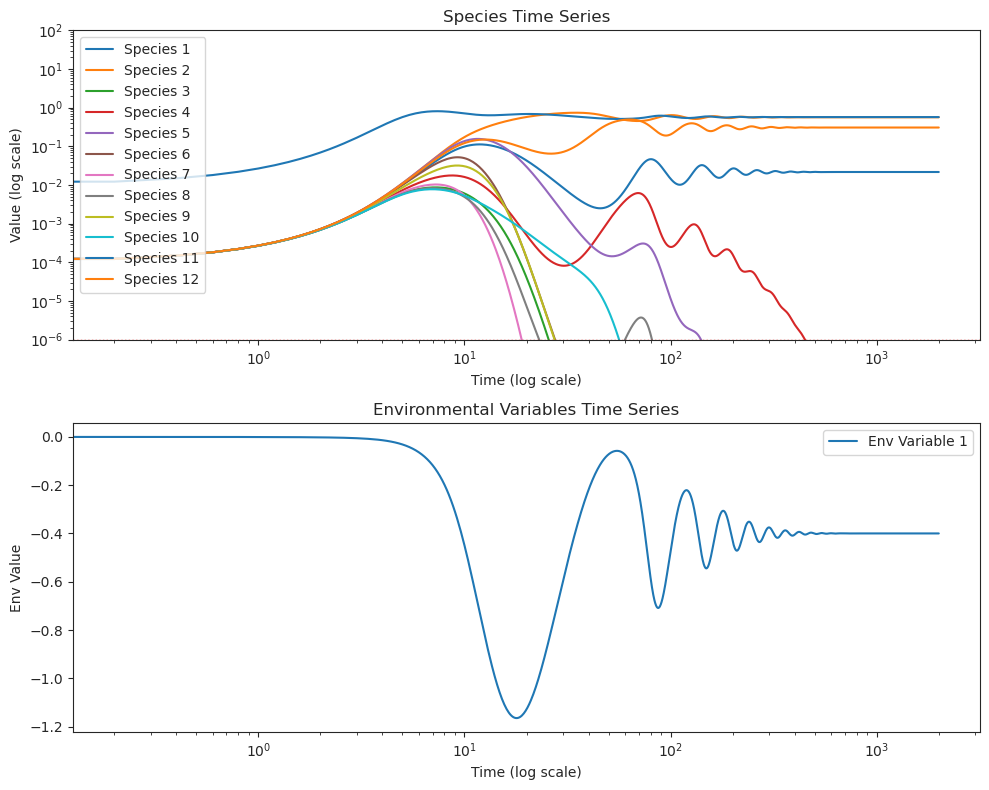

{'species': array([ 2.16528982e-002,  5.63911996e-001, -8.20149270e-246,
        8.61669833e-020,  6.48798485e-071,  2.49929571e-234,
       -7.22697870e-223,  5.76002573e-075, -6.13675973e-218,
        1.62446847e-149,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.4621846289234894 -0.39978192798570633


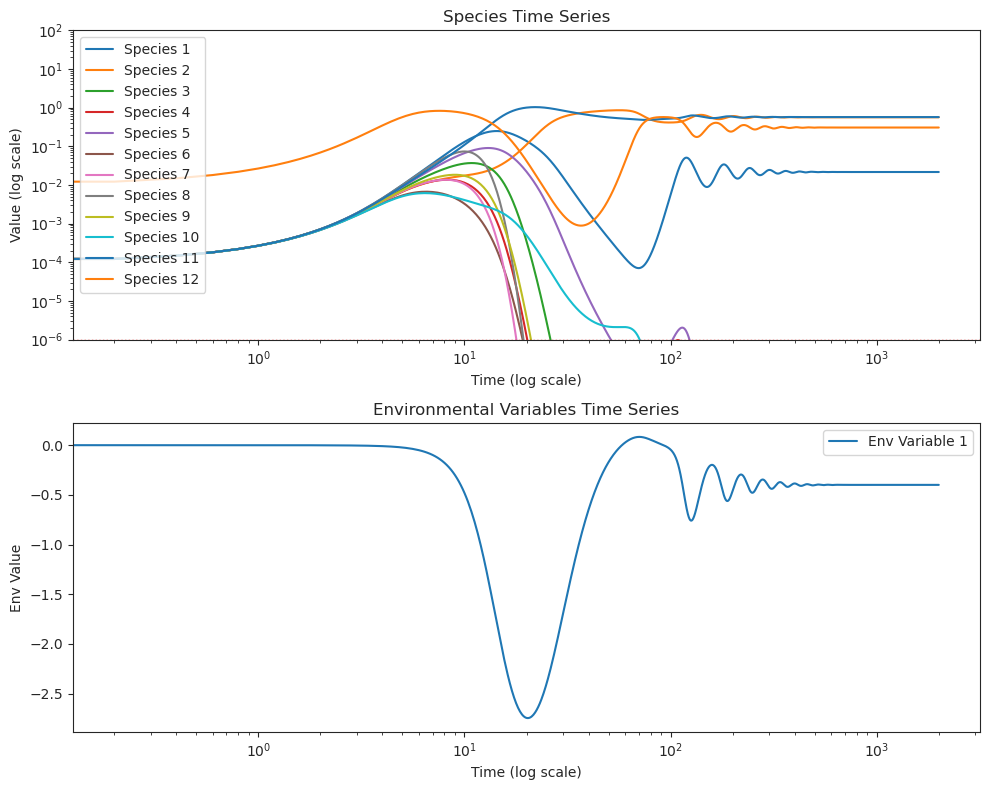

{'species': array([ 2.16528982e-002,  5.63911997e-001,  4.19320614e-266,
        2.40848539e-023, -6.27978659e-073, -6.83292958e-259,
        1.18156904e-226, -1.56781555e-078,  1.51866700e-247,
       -2.32191679e-165,  5.70365502e-001,  3.06254233e-001,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.39978193])}
1.462184628927278 -0.3997819278841008


In [12]:
system_config['beta'] = np.array([1.0])*delta

species_index=np.arange(0,12)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(12,i)
    y0_env=[0]
    t=np.linspace(0, 2000, 10000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)
    print(np.sum(y_out['species']), np.sum(y_out['env']) )

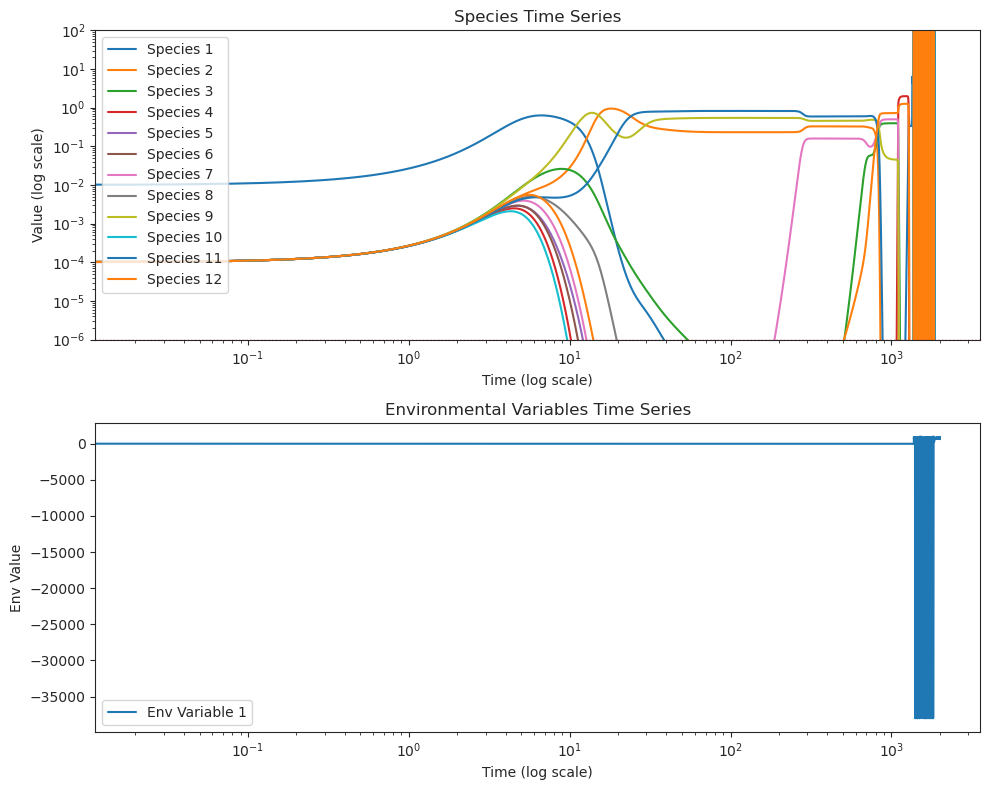

{'species': array([635.47741245, 891.33759653, 635.47477945, 891.33899422,
       635.4721479 , 891.34039188, 635.46951779, 891.34178951,
       635.46688912, 891.34318712, 635.46426189, 891.3445847 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ]), 'env': array([635.46163609])}
9160.871552554847 635.4616360891415


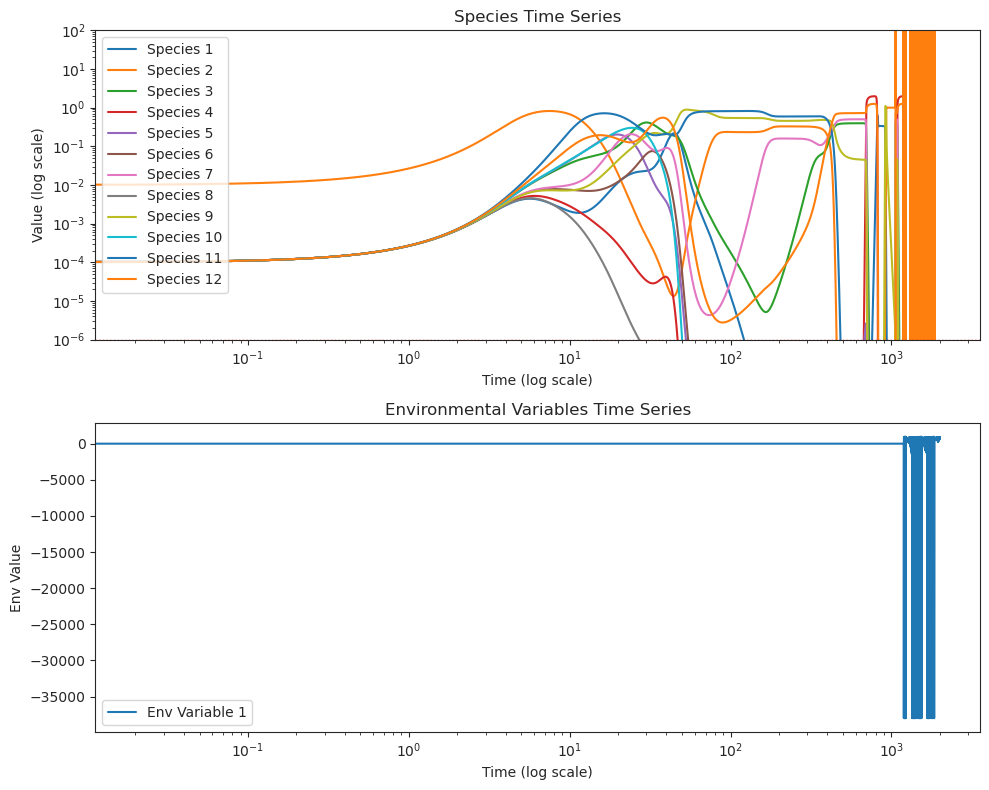

{'species': array([689.01343394, 889.09349467, 689.01343424, 889.0949277 ,
       689.01343453, 889.0963607 , 689.01343483, 889.09779367,
       689.01343513, 889.09922662, 689.01343543, 889.10065953,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ]), 'env': array([689.01343572])}
9468.663070975352 689.0134357225373


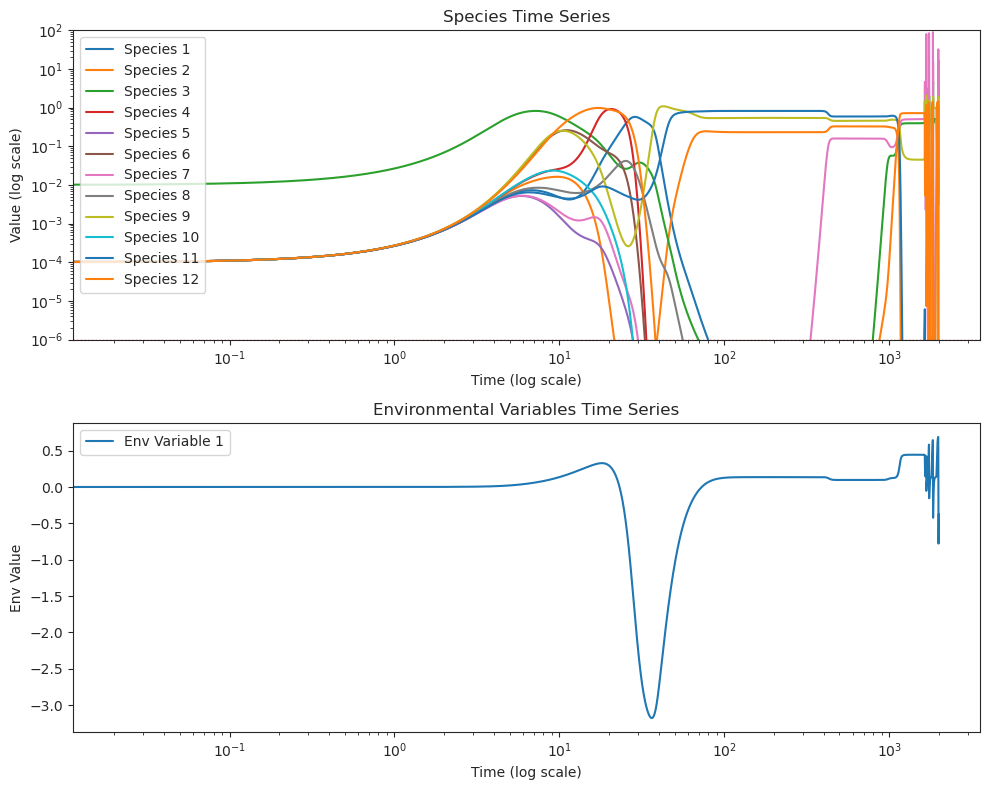

{'species': array([ 1.01474308e-047, -5.98810913e-017,  3.23085237e-001,
       -1.94959532e-004,  2.92030439e-044,  1.78641136e-221,
        5.23494028e-003,  1.18644002e-078,  1.01860774e+000,
        2.70044192e-104,  1.90561038e-071,  7.69147525e-018,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': array([-0.372612])}
1.3467329532391235 -0.3726119994759953


KeyboardInterrupt: 

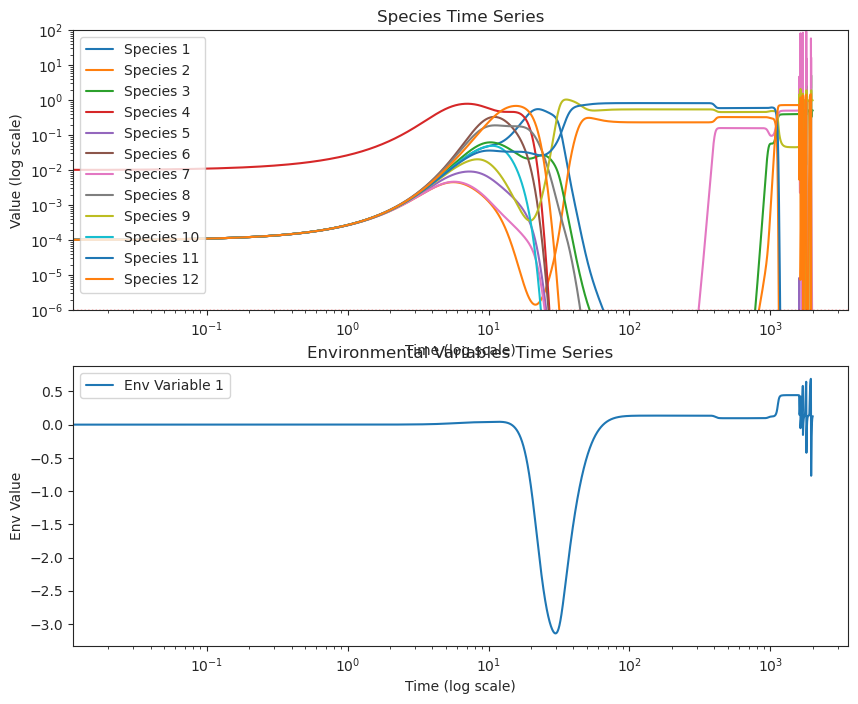

In [25]:
system_config['beta'] = np.array([0.5])*delta

species_index=np.arange(0,12)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(12,i)
    y0_env=[0]
    t=np.linspace(0, 2000, 100000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)
    print(np.sum(y_out['species']), np.sum(y_out['env']) )

In [ ]:
y_out

In [ ]:
np.linspace(0, 1000, 5000)

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([0.002])

for i in range(20):
    species_index=np.random.choice(48, size=12, replace=False)
    env_index=np.array([0])
    y0_species=np.random.rand(12)*0.01
    y0_env=[0]
    t=np.linspace(0, 5000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([0.2])

for i in range(12):
    species_index=np.random.choice(48, size=12, replace=False)
    env_index=np.array([0])
    y0_species=np.random.rand(12)*0.01
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

In [ ]:
system_config

In [ ]:
system_config

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([40])

species_index=np.arange(0,12)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(12,i)
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)